Using device: cuda
--- Generating Training Data ---
Training parameters (p): [3.6    3.6368 3.6737 3.7105 3.7474 3.7842 3.8211 3.8579 3.8947 3.9316
 3.9684 4.0053 4.0421 4.0789 4.1158 4.1526 4.1895 4.2263 4.2632 4.3   ]
Training range: [3.600, 4.300]
Generating training data for p = 3.6000...
Generating training data for p = 3.6368...
Generating training data for p = 3.6737...
Generating training data for p = 3.7105...
Generating training data for p = 3.7474...
Generating training data for p = 3.7842...
Generating training data for p = 3.8211...
Generating training data for p = 3.8579...
Generating training data for p = 3.8947...
Generating training data for p = 3.9316...
Generating training data for p = 3.9684...
Generating training data for p = 4.0053...
Generating training data for p = 4.0421...
Generating training data for p = 4.0789...
Generating training data for p = 4.1158...
Generating training data for p = 4.1526...
Generating training data for p = 4.1895...
Generating trainin

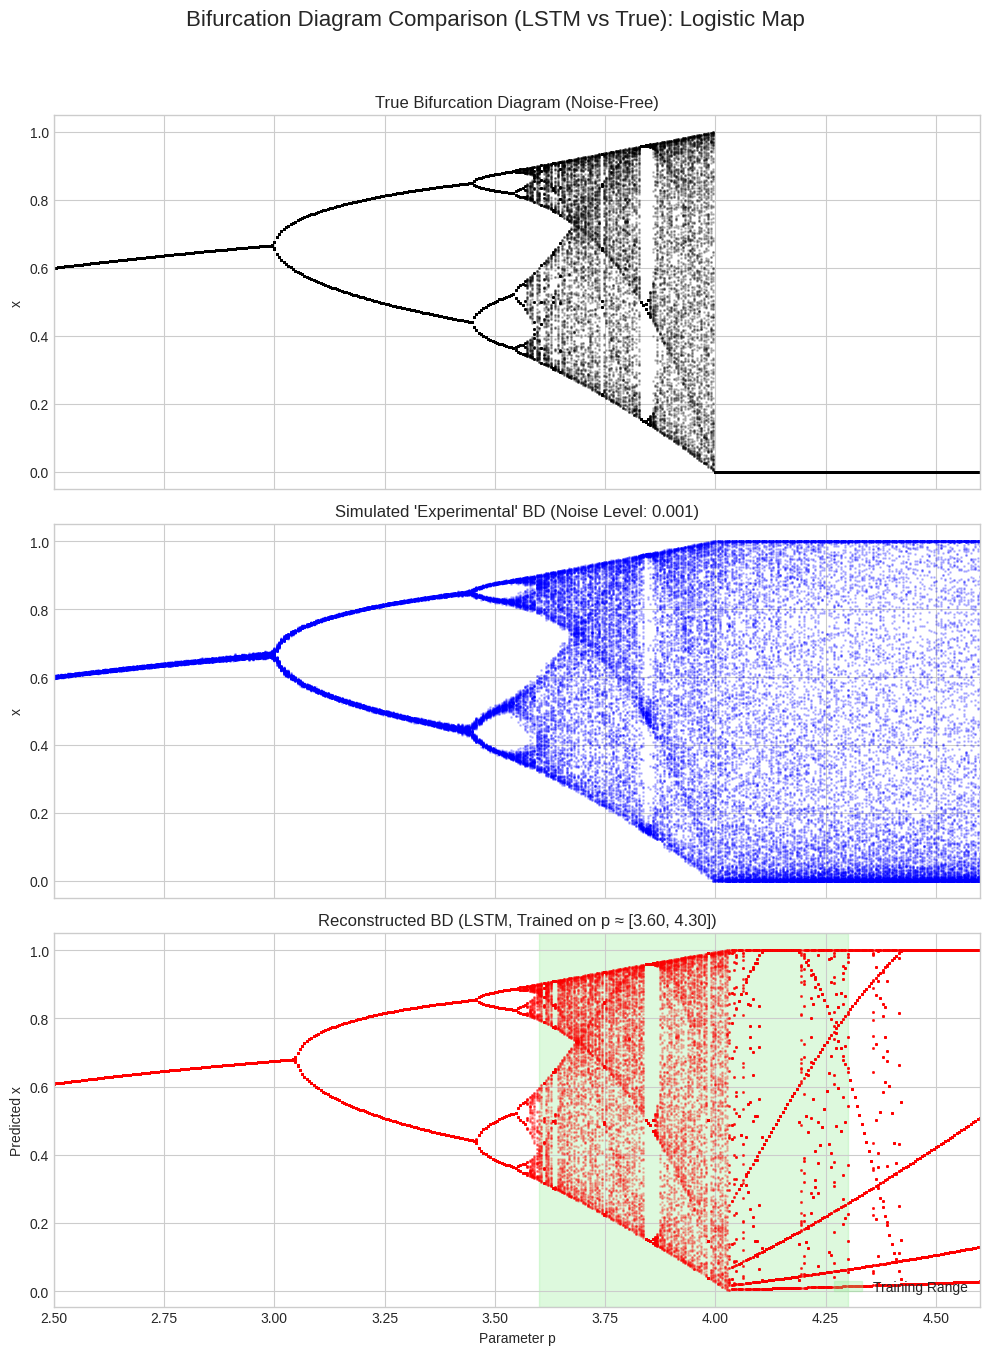

Reconstruction loop finished.
Reconstruction loop finished.


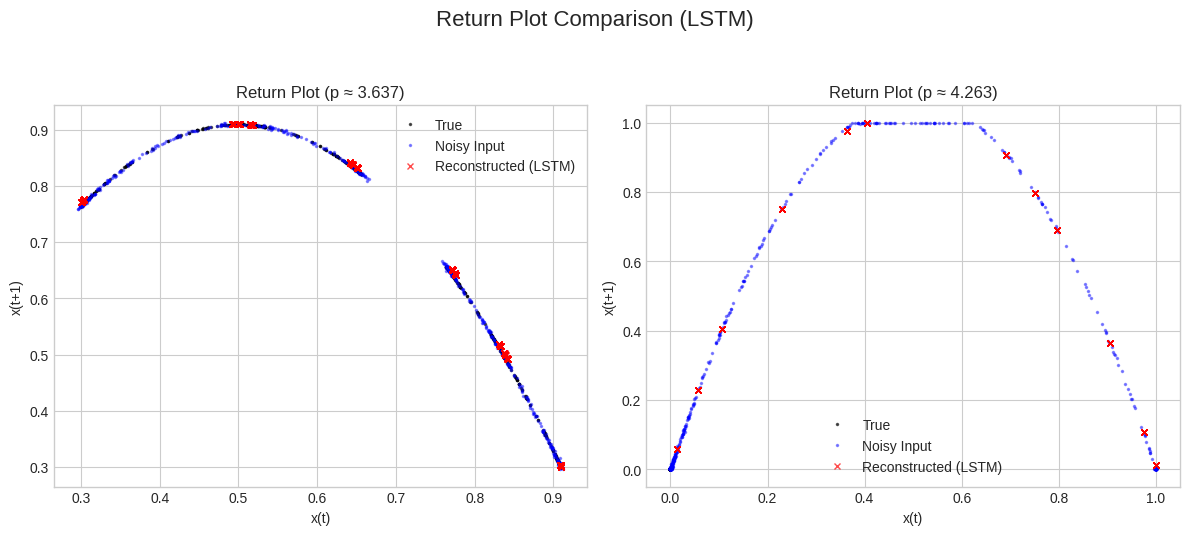

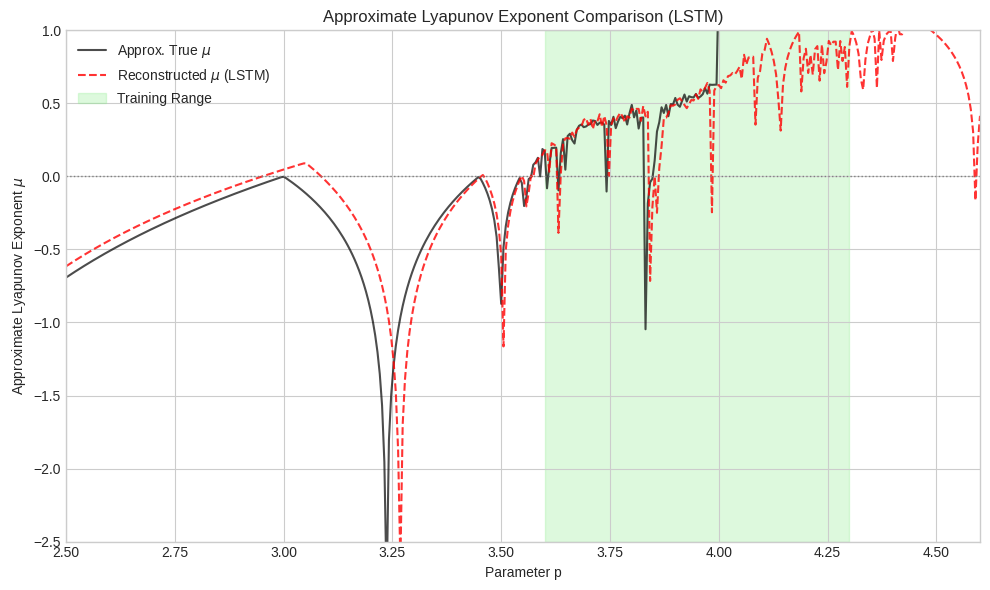


--- End of Simulation ---


In [4]:
# -*- coding: utf-8 -*-
"""
Bifurcation Diagram Reconstruction using LSTM

Adapts the task from the ELM+PCA approach to use a Long Short-Term Memory (LSTM)
network. Trains a single LSTM to predict x(t+1) given x(t) and parameter p.

Note: This method differs from the ELM+PCA approach in Itoh et al. (2020) [2].
It does not use PCA on model weights for parameterization.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
import time

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Data Generation: Logistic Map with Noise ---
def generate_logistic_series(p, x0=0.5, length=1000, transient=500, noise_level=0.0):
    """
    Generates a time series for the logistic map x(t+1) = p*x(t)*(1-x(t)).
    Includes options for dynamical and observational noise.
    """
    x = np.zeros(length + transient)
    x[0] = np.clip(x0, 0, 1) # Ensure initial condition is valid
    for t in range(1, length + transient):
        # Calculate next state
        next_x = p * x[t-1] * (1 - x[t-1])
        # Add dynamical noise (applied before clipping)
        if noise_level > 0:
             next_x += np.random.normal(0, noise_level)
        # Clip to prevent divergence/invalid values
        x[t] = np.clip(next_x, 0, 1)

    series = x[transient:]
    # Add observational noise
    if noise_level > 0:
        series += np.random.normal(0, noise_level, len(series))
    # Final check for NaNs/Infs and clip again if noise pushes outside [0,1]
    series = np.nan_to_num(series, nan=0.5, posinf=1.0, neginf=0.0) # Replace NaN/Inf safely
    series = np.clip(series, 0, 1)
    return series

# --- 2. LSTM Model Definition ---
class LSTMPredictor(nn.Module):
    def __init__(self, input_size=2, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM layer: input_size includes x(t) and parameter p
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer to map LSTM output to prediction
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, p_val):
        # x shape: (batch_size, seq_len, 1) for state
        # p_val shape: (batch_size, seq_len, 1) for parameter
        
        # Concatenate state and parameter along the feature dimension
        combined_input = torch.cat((x, p_val), dim=2) # Shape: (batch_size, seq_len, 2)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, combined_input.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, combined_input.size(0), self.hidden_size).to(device)

        # Pass through LSTM
        out, _ = self.lstm(combined_input, (h0, c0)) # out shape: (batch_size, seq_len, hidden_size)

        # Pass the output of the last time step through the fully connected layer
        out = self.fc(out[:, -1, :]) # Use only the last output for prediction, shape: (batch_size, output_size)
        return out

# --- 3. Training Function ---
def train_lstm(model, dataloader, criterion, optimizer, num_epochs):
    print("Starting LSTM Training...")
    model.train() # Set model to training mode
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (inputs_x, inputs_p, targets) in enumerate(dataloader):
            inputs_x = inputs_x.to(device) # Shape: (batch_size, seq_len, 1)
            inputs_p = inputs_p.to(device) # Shape: (batch_size, seq_len, 1)
            targets = targets.to(device)   # Shape: (batch_size, 1)

            # Forward pass
            outputs = model(inputs_x, inputs_p)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0 or epoch == 0:
             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}')

    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f} seconds.")
    return model

# --- 4. Data Preparation for LSTM ---
def prepare_lstm_data(all_series_data, p_values, sequence_length=1):
    """Prepares data for LSTM training with parameter p as input."""
    sequences_x = []
    sequences_p = []
    targets_y = []

    for p in p_values:
        series = all_series_data[p]
        if len(series) <= sequence_length:
            continue # Skip if series is too short

        # Create sequences of [x(t)] and [p] as input, x(t+1) as target
        for i in range(len(series) - sequence_length):
            seq_x = series[i : i + sequence_length]
            seq_p = np.full(sequence_length, p) # Repeat p for the sequence length
            target = series[i + sequence_length]

            sequences_x.append(seq_x)
            sequences_p.append(seq_p)
            targets_y.append(target)

    # Convert to numpy arrays
    sequences_x = np.array(sequences_x)
    sequences_p = np.array(sequences_p)
    targets_y = np.array(targets_y)

    # Reshape for LSTM: (num_samples, seq_len, num_features)
    # Features for x is 1, features for p is 1
    sequences_x = sequences_x.reshape(-1, sequence_length, 1)
    sequences_p = sequences_p.reshape(-1, sequence_length, 1)
    targets_y = targets_y.reshape(-1, 1) # Target is single value

    # Convert to PyTorch tensors
    sequences_x_tensor = torch.tensor(sequences_x, dtype=torch.float32)
    sequences_p_tensor = torch.tensor(sequences_p, dtype=torch.float32)
    targets_y_tensor = torch.tensor(targets_y, dtype=torch.float32)

    return TensorDataset(sequences_x_tensor, sequences_p_tensor, targets_y_tensor)


# --- 5. Simulation Parameters ---
# Training Range Parameters
N_PARAMS_TRAIN = 20
# p_values_train = np.array([-0.15 * np.cos(2 * np.pi * (n - 1) / 8) + 3.7 for n in range(1, N_PARAMS_TRAIN + 1)])
# TRAIN_RANGE = (p_values_train.min(), p_values_train.max())
# Define training parameters uniformly between 3.0 and 4.0
TRAIN_RANGE = (3.6, 4.3)
p_values_train = np.linspace(TRAIN_RANGE[0], TRAIN_RANGE[1], N_PARAMS_TRAIN)
# Extended Range for Reconstruction
EXTENDED_RANGE = (2.5, 4.6)
p_range_extended = np.linspace(EXTENDED_RANGE[0], EXTENDED_RANGE[1], 400)

# LSTM Hyperparameters
INPUT_SIZE = 2       # x(t) and p
HIDDEN_SIZE = 32     # Number of LSTM units
NUM_LAYERS = 1
OUTPUT_SIZE = 1      # Predicting x(t+1)
SEQUENCE_LENGTH = 1  # Use only the previous time step x(t) to predict x(t+1)
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 64

# Data Generation Parameters
NOISE_LEVEL = 0.001 # Noise added to data generation
DATA_LENGTH = 1500
TRANSIENT = 500

# Reconstruction Parameters
PRED_WARMUP = 300   # Steps to discard before collecting points
PRED_POINTS = 200   # Number of attractor points to collect per parameter

# --- 6. Generate Training Data ---
print("--- Generating Training Data ---")
print(f"Training parameters (p): {np.round(p_values_train, 4)}")
print(f"Training range: [{TRAIN_RANGE[0]:.3f}, {TRAIN_RANGE[1]:.3f}]")

all_series_train = {}
for p in p_values_train:
    print(f"Generating training data for p = {p:.4f}...")
    x_noisy = generate_logistic_series(p, length=DATA_LENGTH, transient=TRANSIENT, noise_level=NOISE_LEVEL)
    all_series_train[p] = x_noisy

# --- 7. Prepare DataLoaders ---
print("\n--- Preparing Data for LSTM ---")
train_dataset = prepare_lstm_data(all_series_train, p_values_train, sequence_length=SEQUENCE_LENGTH)
if len(train_dataset) == 0:
     raise ValueError("No valid training sequences generated. Check data length and sequence length.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Total training samples (sequences): {len(train_dataset)}")

# --- 8. Initialize and Train LSTM Model ---
print("\n--- Training LSTM Model ---")
lstm_model = LSTMPredictor(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=OUTPUT_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

# Train the model
lstm_model = train_lstm(lstm_model, train_loader, criterion, optimizer, NUM_EPOCHS)

# --- 9. Bifurcation Diagram Reconstruction with LSTM ---
print("\n--- Reconstruction Phase (LSTM) ---")

def reconstruct_bifurcation_lstm(model, p_values, n_predict_points=PRED_POINTS, n_discard_transient=PRED_WARMUP, seq_len=SEQUENCE_LENGTH):
    """
    Reconstructs the bifurcation diagram using the trained LSTM autonomously.
    The parameter 'p' is provided as input to the model at each step.
    """
    model.eval() # Set model to evaluation mode
    all_p_recon = []
    all_x_recon = []

    with torch.no_grad(): # Disable gradient calculation for prediction
        for p in p_values:
            # print(f"Reconstructing for p = {p:.4f}...") # Can be verbose
            x_pred_segment = []
            
            # Initialize sequence with random start or fixed start
            current_sequence_x = torch.rand(1, seq_len, 1).to(device) * 0.5 + 0.25 # Start near middle
            
            # Prepare parameter tensor (constant for this p)
            p_tensor = torch.full((1, seq_len, 1), p, dtype=torch.float32).to(device)

            # Autonomous prediction loop
            for t in range(n_discard_transient + n_predict_points):
                # Predict the next step
                # Input shapes: (batch=1, seq_len, features=1)
                next_x_pred_tensor = model(current_sequence_x, p_tensor) # Output shape: (1, 1)
                
                # Get the scalar prediction value and clip
                next_x_pred = next_x_pred_tensor.item()
                current_x = np.clip(next_x_pred, 0, 1) # Clip prediction
                
                # Update the sequence for the next prediction step
                # Shift sequence left and add new prediction at the end
                new_x_tensor = torch.tensor([[[current_x]]], dtype=torch.float32).to(device)
                if seq_len > 1:
                     current_sequence_x = torch.cat((current_sequence_x[:, 1:, :], new_x_tensor), dim=1)
                else:
                     current_sequence_x = new_x_tensor # Replace if seq_len is 1

                # Store points after discard phase
                if t >= n_discard_transient:
                    x_pred_segment.append(current_x)

            all_p_recon.extend([p] * len(x_pred_segment))
            all_x_recon.extend(x_pred_segment)

    print("Reconstruction loop finished.")
    if not all_p_recon:
         print("Warning: Reconstruction produced no points.")
         return np.array([]), np.array([])

    return np.array(all_p_recon), np.array(all_x_recon)

# Reconstruct over the extended range using the trained LSTM
p_recon, x_recon = reconstruct_bifurcation_lstm(lstm_model, p_range_extended)

# --- 10. Generate True and Noisy Bifurcation Diagrams for Comparison ---
# (Same as before)
print("\nGenerating comparison diagrams...")
def generate_bd_points(p_values, length=PRED_POINTS, transient=TRANSIENT, noise=0.0):
    """Generates points for a bifurcation diagram."""
    all_p = []
    all_x = []
    for p in p_values:
        x_series = generate_logistic_series(p, x0=0.5, length=length, transient=transient, noise_level=noise)
        all_p.extend([p] * len(x_series))
        all_x.extend(x_series)
    return np.array(all_p), np.array(all_x)

p_true, x_true = generate_bd_points(p_range_extended, noise=0.0)
p_noisy, x_noisy_bd = generate_bd_points(p_range_extended, noise=NOISE_LEVEL)

# --- 11. Calculate Approximate Lyapunov Exponent ---
# Using the same approximation based on the logistic map derivative
# A more accurate method would involve calculating the Jacobian of the LSTM,
# which is complex. This approximation assumes the LSTM learned the map well.
def approx_lyapunov_exponent(p_vals, x_vals):
    """Approximates Lyapunov exponent using logistic map derivative on attractor points."""
    lyap_exps = {}
    for p, x in zip(p_vals, x_vals):
        if p not in lyap_exps:
            lyap_exps[p] = []
        deriv = p * (1.0 - 2.0 * x)
        if abs(deriv) > 1e-9:
             lyap_exps[p].append(np.log(np.abs(deriv)))
    
    unique_p = sorted(lyap_exps.keys())
    mean_lyap = []
    for p in unique_p:
        if lyap_exps[p]:
             mean_lyap.append(np.mean(lyap_exps[p]))
        else:
             mean_lyap.append(np.nan)

    mean_lyap = np.nan_to_num(np.array(mean_lyap), nan=-1.0)
    return np.array(unique_p), mean_lyap

# Calculate Lyapunov for reconstructed and true diagrams
if p_recon.size > 0:
    p_lyap_recon, mu_recon = approx_lyapunov_exponent(p_recon, x_recon)
else:
    p_lyap_recon, mu_recon = np.array([]), np.array([])

p_lyap_true, mu_true = approx_lyapunov_exponent(p_true, x_true)


# --- 12. Visualizations ---
print("\nGenerating plots...")
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    print("Seaborn style not found, using default.")
    pass

# Figure 1: Bifurcation Diagrams Comparison
fig1, axs1 = plt.subplots(3, 1, figsize=(10, 14), sharex=True)
marker_size = 1.0
alpha_val = 0.2

# (a) True Bifurcation Diagram
axs1[0].scatter(p_true, x_true, s=marker_size, c='black', alpha=alpha_val)
axs1[0].set_title(f"True Bifurcation Diagram (Noise-Free)")
axs1[0].set_ylabel("x")
axs1[0].grid(True)

# (b) Noisy Bifurcation Diagram (used for training)
axs1[1].scatter(p_noisy, x_noisy_bd, s=marker_size, c='blue', alpha=alpha_val)
axs1[1].set_title(f"Simulated 'Experimental' BD (Noise Level: {NOISE_LEVEL})")
axs1[1].set_ylabel("x")
axs1[1].grid(True)

# (c) Reconstructed Bifurcation Diagram (LSTM)
if p_recon.size > 0:
    axs1[2].scatter(p_recon, x_recon, s=marker_size, c='red', alpha=alpha_val)
else:
    axs1[2].text(0.5, 0.5, "Reconstruction failed", ha='center', va='center', transform=axs1[2].transAxes)
axs1[2].axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.3, zorder=-1, label='Training Range')
axs1[2].set_title(f"Reconstructed BD (LSTM, Trained on p ≈ [{TRAIN_RANGE[0]:.2f}, {TRAIN_RANGE[1]:.2f}])")
axs1[2].set_xlabel("Parameter p")
axs1[2].set_ylabel("Predicted x")
axs1[2].legend(loc='lower right')
axs1[2].set_xlim(EXTENDED_RANGE)
axs1[2].grid(True)

fig1.suptitle("Bifurcation Diagram Comparison (LSTM vs True): Logistic Map", fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Figure 2: Return Plots Comparison
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5.5))
p_periodic = p_values_train[1] # ~3.55
p_chaotic = p_values_train[-2] # ~3.85
# p_periodic = p_range_extended[200]
# p_chaotic = p_range_extended[300]

if p_periodic not in all_series_train or p_chaotic not in all_series_train:
    print("Warning: Data for selected return plot parameters not available in training data.")
else:
    # True data
    x_true_p = generate_logistic_series(p_periodic, length=500, transient=TRANSIENT, noise_level=0.0)
    x_true_c = generate_logistic_series(p_chaotic, length=500, transient=TRANSIENT, noise_level=0.0)
    
    # Noisy input data
    x_noisy_p = all_series_train[p_periodic][-500:]
    x_noisy_c = all_series_train[p_chaotic][-500:]

    # Generate reconstructed data points using LSTM
    _, x_recon_p_full = reconstruct_bifurcation_lstm(lstm_model, np.array([p_periodic]), n_predict_points=500, n_discard_transient=100)
    _, x_recon_c_full = reconstruct_bifurcation_lstm(lstm_model, np.array([p_chaotic]), n_predict_points=500, n_discard_transient=100)

    # Plotting
    if len(x_true_p) > 1:
        axs2[0].plot(x_true_p[:-1], x_true_p[1:], 'k.', markersize=3, alpha=0.6, label='True')
        axs2[0].plot(x_noisy_p[:-1], x_noisy_p[1:], 'b.', markersize=3, alpha=0.4, label=f'Noisy Input')
        if len(x_recon_p_full) > 1:
             axs2[0].plot(x_recon_p_full[:-1], x_recon_p_full[1:], 'rx', markersize=4, alpha=0.7, label='Reconstructed (LSTM)')
        axs2[0].set_title(f"Return Plot (p ≈ {p_periodic:.3f})")
        axs2[0].set_xlabel("x(t)")
        axs2[0].set_ylabel("x(t+1)")
        axs2[0].legend()
        axs2[0].grid(True)
    else:
        axs2[0].text(0.5, 0.5, f"No data for p={p_periodic:.3f}", ha='center', va='center', transform=axs2[0].transAxes)

    if len(x_true_c) > 1:
        axs2[1].plot(x_true_c[:-1], x_true_c[1:], 'k.', markersize=3, alpha=0.6, label='True')
        axs2[1].plot(x_noisy_c[:-1], x_noisy_c[1:], 'b.', markersize=3, alpha=0.4, label=f'Noisy Input')
        if len(x_recon_c_full) > 1:
            axs2[1].plot(x_recon_c_full[:-1], x_recon_c_full[1:], 'rx', markersize=4, alpha=0.7, label='Reconstructed (LSTM)')
        axs2[1].set_title(f"Return Plot (p ≈ {p_chaotic:.3f})")
        axs2[1].set_xlabel("x(t)")
        axs2[1].set_ylabel("x(t+1)")
        axs2[1].legend()
        axs2[1].grid(True)
    else:
         axs2[1].text(0.5, 0.5, f"No data for p={p_chaotic:.3f}", ha='center', va='center', transform=axs2[1].transAxes)

    fig2.suptitle("Return Plot Comparison (LSTM)", fontsize=16, y=0.995)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Figure 3: Lyapunov Exponent Comparison
fig3, ax3 = plt.subplots(figsize=(10, 6))

if p_lyap_true.size > 0:
    ax3.plot(p_lyap_true, mu_true, 'k-', lw=1.5, alpha=0.7, label='Approx. True $\mu$')
if p_lyap_recon.size > 0:
    ax3.plot(p_lyap_recon, mu_recon, 'r--', lw=1.5, alpha=0.8, label='Reconstructed $\mu$ (LSTM)')
else:
    ax3.text(0.5, 0.5, "Lyapunov reconstruction failed", ha='center', va='center', transform=ax3.transAxes)

ax3.axhline(0, color='gray', linestyle=':', linewidth=1)
ax3.axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.3, zorder=-1, label='Training Range')

ax3.set_title("Approximate Lyapunov Exponent Comparison (LSTM)")
ax3.set_xlabel("Parameter p")
ax3.set_ylabel("Approximate Lyapunov Exponent $\mu$")
ax3.set_ylim(-2.5, 1)
ax3.set_xlim(EXTENDED_RANGE)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print("\n--- End of Simulation ---")



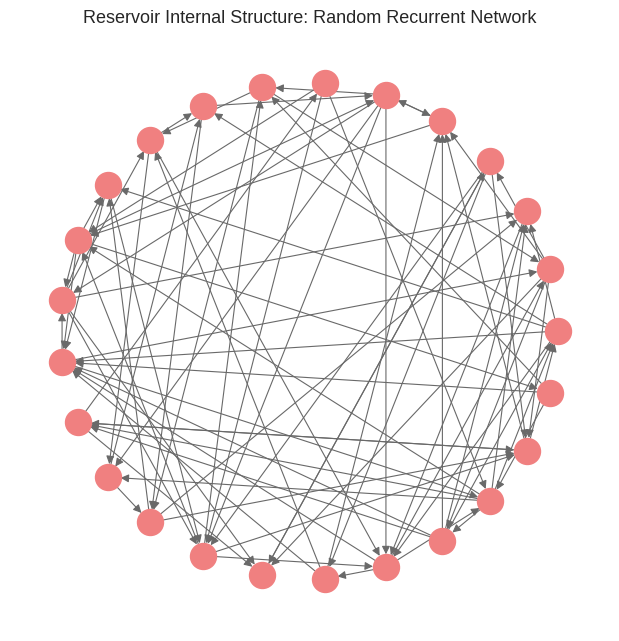

In [7]:
## for logistic paper

Epoch [100/2000], Train Loss: 0.0182, Test Loss: 0.0421
Epoch [200/2000], Train Loss: 0.0129, Test Loss: 0.0971
Epoch [300/2000], Train Loss: 0.0116, Test Loss: 0.0793
Epoch [400/2000], Train Loss: 0.0097, Test Loss: 0.0355
Epoch [500/2000], Train Loss: 0.0083, Test Loss: 0.0405
Epoch [600/2000], Train Loss: 0.0067, Test Loss: 0.1247
Epoch [700/2000], Train Loss: 0.0058, Test Loss: 0.3423
Epoch [800/2000], Train Loss: 0.0055, Test Loss: 0.4123
Epoch [900/2000], Train Loss: 0.0052, Test Loss: 0.4837
Epoch [1000/2000], Train Loss: 0.0049, Test Loss: 0.5752
Epoch [1100/2000], Train Loss: 0.0046, Test Loss: 0.6892
Epoch [1200/2000], Train Loss: 0.0043, Test Loss: 0.8209
Epoch [1300/2000], Train Loss: 0.0039, Test Loss: 0.9551
Epoch [1400/2000], Train Loss: 0.0031, Test Loss: 1.1375
Epoch [1500/2000], Train Loss: 0.0016, Test Loss: 1.4097
Epoch [1600/2000], Train Loss: 0.0009, Test Loss: 1.5587
Epoch [1700/2000], Train Loss: 0.0006, Test Loss: 1.6160
Epoch [1800/2000], Train Loss: 0.0004, T

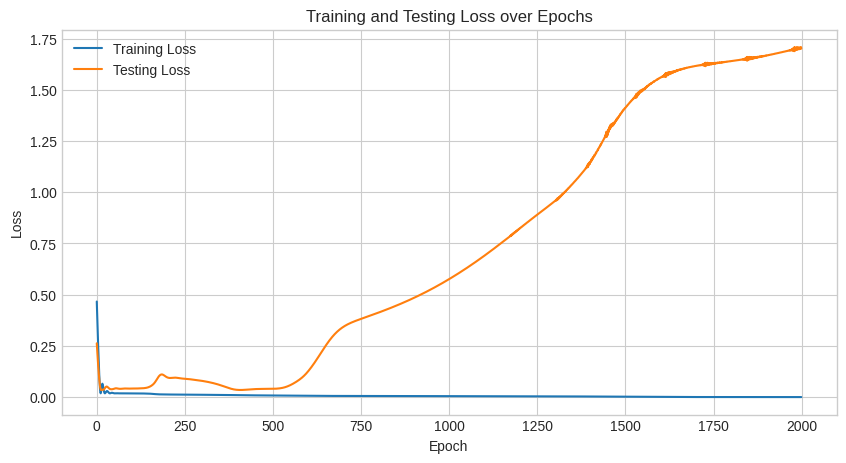

Root Mean Square Error (RMSE): 1.366648e+02
Normalized Root Mean Square Error (NRMSE): 3.520168e+00


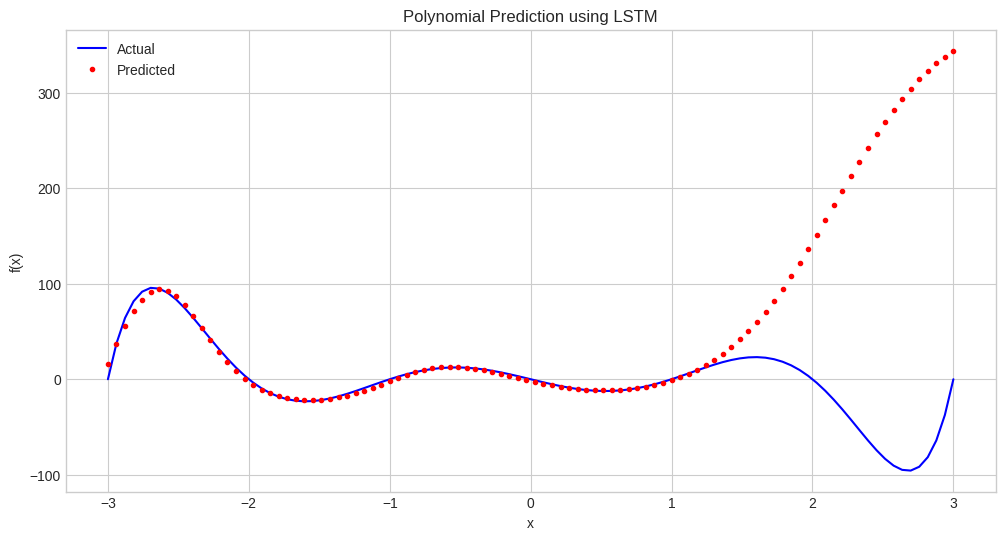

Noisy Data - Epoch [500/2000], Loss: 0.0118
Noisy Data - Epoch [1000/2000], Loss: 0.0023
Noisy Data - Epoch [1500/2000], Loss: 0.0017
Noisy Data - Epoch [2000/2000], Loss: 0.0015
Noisy Data - RMSE: 7.439763e+00
Noisy Data - NRMSE: 1.916310e-01


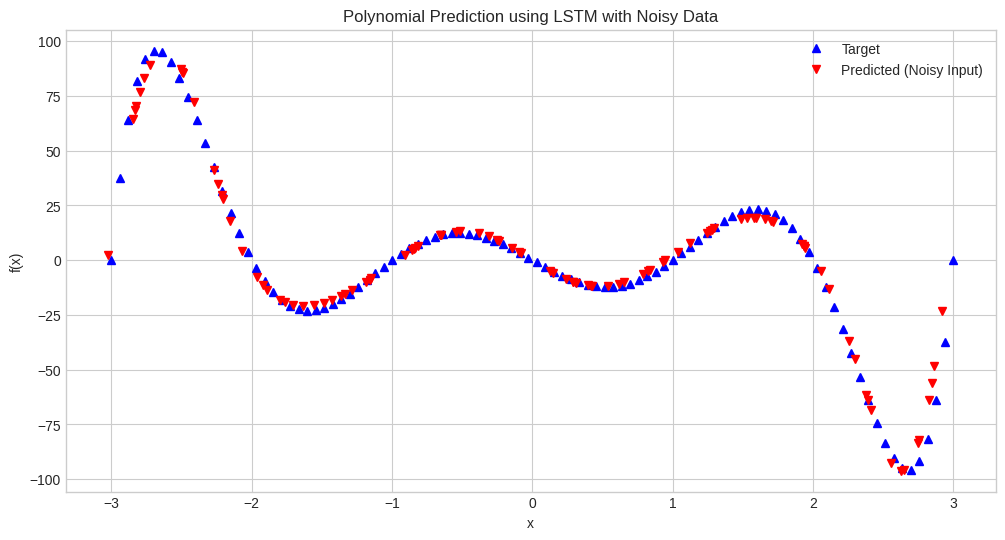

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

# Define the seventh-degree polynomial function
def polynomial_function(x):
    return (x-3)*(x-2)*(x-1)*x*(x+1)*(x+2)*(x+3)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate data
x_min, x_max = -3, 3
num_samples = 100
x_data = np.linspace(x_min, x_max, num_samples).reshape(-1, 1)
y_data = np.array([polynomial_function(x) for x in x_data]).reshape(-1, 1)

# Scale the data
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(x_data)
y_scaled = y_scaler.fit_transform(y_data)

# Split data into training and testing sets
train_size = int(len(x_data) * 0.7)
x_train, x_test = x_scaled[:train_size], x_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Convert to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train).view(-1, 1, 1)
y_train_tensor = torch.FloatTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test).view(-1, 1, 1)
y_test_tensor = torch.FloatTensor(y_test)

# Define LSTM model for non-temporal task
class PolynomialLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(PolynomialLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # Use the output of the last time step
        output = self.fc(lstm_out[:, -1, :])
        return output

# Instantiate the model
model = PolynomialLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 2000
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Forward pass
    model.train()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
    
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
model.eval()
with torch.no_grad():
    # Predict on the entire dataset
    x_all_tensor = torch.FloatTensor(x_scaled).view(-1, 1, 1)
    predicted_scaled = model(x_all_tensor).numpy()
    predicted = y_scaler.inverse_transform(predicted_scaled)
    
    # Compute metrics
    y_true = y_data
    rmse = np.sqrt(mean_squared_error(y_true, predicted))
    y_avg = np.mean(y_true)
    nrmse = rmse / np.sqrt(np.mean((y_true - y_avg)**2))
    
    print(f"Root Mean Square Error (RMSE): {rmse:.6e}")
    print(f"Normalized Root Mean Square Error (NRMSE): {nrmse:.6e}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(x_data, y_data, 'b-', label='Actual')
plt.plot(x_data, predicted, 'ro', markersize=3, label='Predicted')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Polynomial Prediction using LSTM')
plt.legend()
plt.grid(True)
plt.show()

# Add noise and test robustness
def add_noise(data, noise_level=0.1):
    noise = np.random.uniform(-noise_level, noise_level, size=data.shape)
    return data + noise

# Add noise to input and output
noise_level = 0.1
x_noisy = add_noise(x_data, noise_level)
y_noisy = add_noise(y_data, noise_level)

# Scale noisy data
x_noisy_scaled = x_scaler.transform(x_noisy)
y_noisy_scaled = y_scaler.transform(y_noisy)

# Convert to PyTorch tensors
x_noisy_tensor = torch.FloatTensor(x_noisy_scaled).view(-1, 1, 1)
y_noisy_tensor = torch.FloatTensor(y_noisy_scaled)

# Train new model with noisy data
model_noisy = PolynomialLSTM()
optimizer_noisy = optim.Adam(model_noisy.parameters(), lr=0.01)

# Train the model with noisy data
for epoch in range(num_epochs):
    # Forward pass
    model_noisy.train()
    outputs = model_noisy(x_noisy_tensor)
    loss = criterion(outputs, y_noisy_tensor)
    
    # Backward and optimize
    optimizer_noisy.zero_grad()
    loss.backward()
    optimizer_noisy.step()
    
    if (epoch+1) % 500 == 0:
        print(f'Noisy Data - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions with noisy data
model_noisy.eval()
with torch.no_grad():
    predicted_noisy_scaled = model_noisy(x_noisy_tensor).numpy()
    predicted_noisy = y_scaler.inverse_transform(predicted_noisy_scaled)
    
    # Compute metrics
    rmse_noisy = np.sqrt(mean_squared_error(y_data, predicted_noisy))
    nrmse_noisy = rmse_noisy / np.sqrt(np.mean((y_data - np.mean(y_data))**2))
    
    print(f"Noisy Data - RMSE: {rmse_noisy:.6e}")
    print(f"Noisy Data - NRMSE: {nrmse_noisy:.6e}")

# Plot results with noisy data
plt.figure(figsize=(12, 6))
plt.plot(x_data, y_data, 'b^', label='Target')
plt.plot(x_noisy, predicted_noisy, 'rv', label='Predicted (Noisy Input)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Polynomial Prediction using LSTM with Noisy Data')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/300, Train Loss: 0.2775, Val Loss: 0.2859
Epoch 51/300, Train Loss: 0.0319, Val Loss: 0.0341
Epoch 101/300, Train Loss: 0.0139, Val Loss: 0.0126
Epoch 151/300, Train Loss: 0.0136, Val Loss: 0.0122
Epoch 201/300, Train Loss: 0.0134, Val Loss: 0.0121
Epoch 251/300, Train Loss: 0.0131, Val Loss: 0.0120


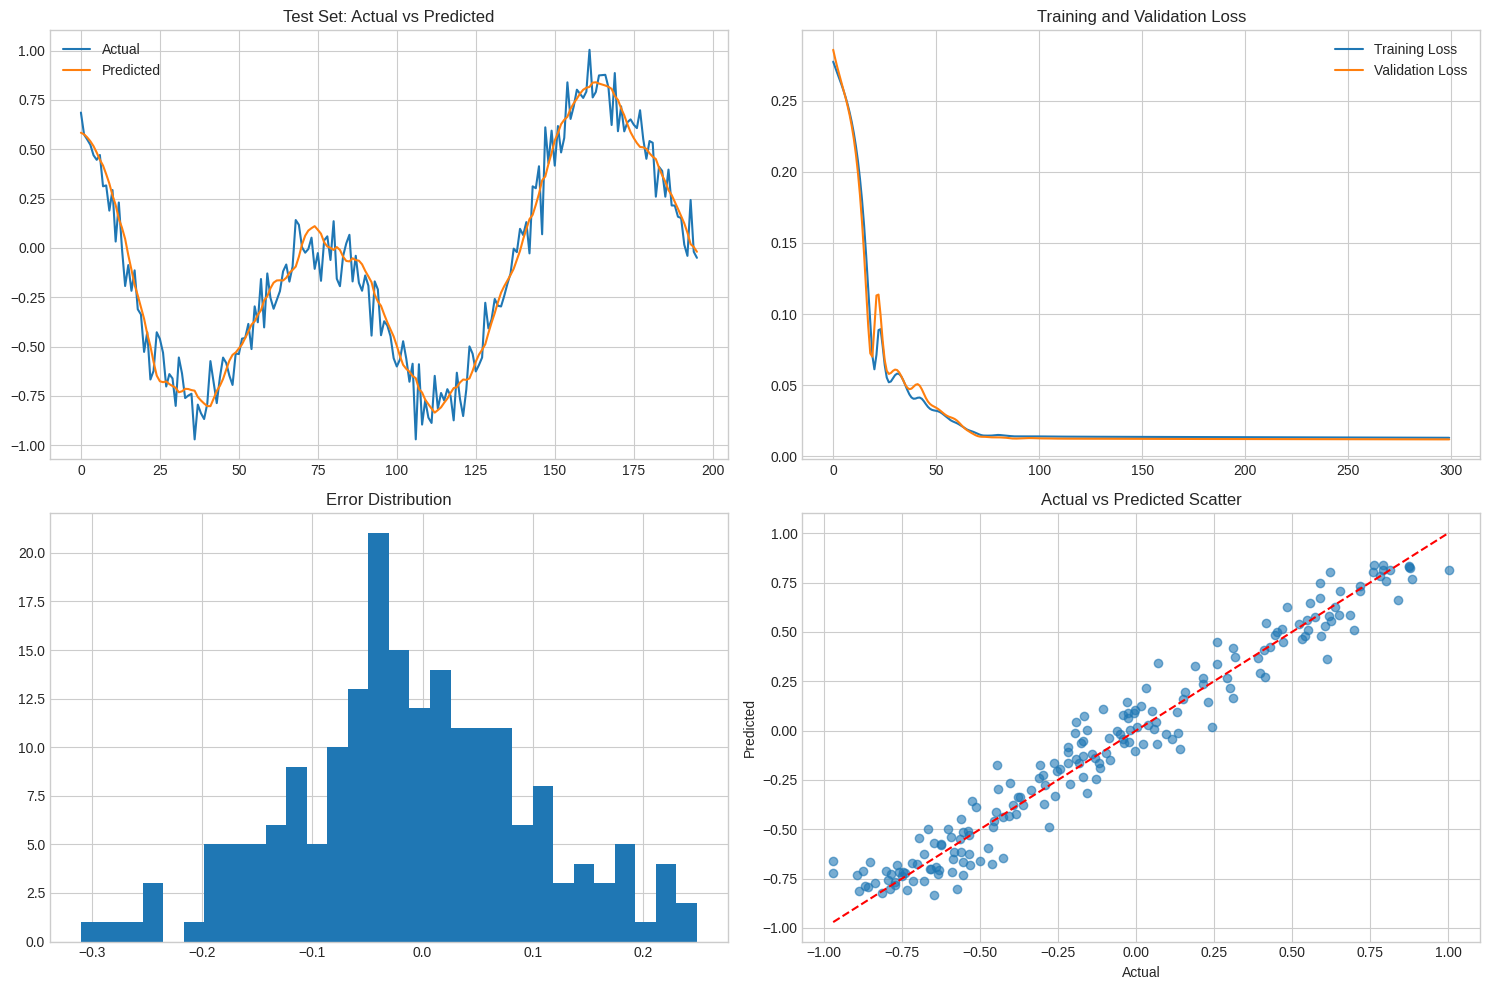


Training Metrics:
RMSE: 0.1129, MAE: 0.0895, R²: 0.9524

Test Metrics:
RMSE: 0.1079, MAE: 0.0847, R²: 0.9551


In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Synthetic data generation (replace with your data loading logic)
def generate_sine_wave(length=1000):
    x = np.linspace(0, 50, length)
    return np.sin(x) * np.sin(x*0.5) + np.random.normal(0, 0.1, length)

# Data preprocessing
def create_sequences(data, lookback=10):
    X, y = [], []
    for i in range(len(data)-lookback-1):
        X.append(data[i:(i+lookback)])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

# Configuration
LOOKBACK = 20
HIDDEN_SIZE = 64
NUM_LAYERS = 2
EPOCHS = 300
BATCH_SIZE = 32

# Prepare data
data = generate_sine_wave()[:, None]
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

X, y = create_sequences(scaled_data, LOOKBACK)
X = torch.tensor(X).float()
y = torch.tensor(y).float()

# Split dataset
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM Model
class TimeSeriesLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=HIDDEN_SIZE,
                          num_layers=NUM_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1]
        x = self.linear(x)
        return x

model = TimeSeriesLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
train_losses, val_losses = [], []
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test)
        val_loss = criterion(val_preds, y_test)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Final predictions
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

# Inverse scaling
y_train_actual = scaler.inverse_transform(y_train.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())
train_pred_actual = scaler.inverse_transform(train_pred.numpy())
test_pred_actual = scaler.inverse_transform(test_pred.numpy())

# Calculate metrics
def calculate_metrics(actual, pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, pred)),
        'MAE': mean_absolute_error(actual, pred),
        'R²': r2_score(actual, pred)
    }

train_metrics = calculate_metrics(y_train_actual, train_pred_actual)
test_metrics = calculate_metrics(y_test_actual, test_pred_actual)

# Visualization
plt.figure(figsize=(15, 10))

# Actual vs Predicted
plt.subplot(2, 2, 1)
plt.plot(y_test_actual, label='Actual')
plt.plot(test_pred_actual, label='Predicted')
plt.title('Test Set: Actual vs Predicted')
plt.legend()

# Loss Curves
plt.subplot(2, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Error Distribution
plt.subplot(2, 2, 3)
errors = y_test_actual - test_pred_actual
plt.hist(errors, bins=30)
plt.title('Error Distribution')

# Prediction vs Actual Scatter
plt.subplot(2, 2, 4)
plt.scatter(y_test_actual, test_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Scatter')

plt.tight_layout()
plt.show()

# Print metrics
print("\nTraining Metrics:")
print(f"RMSE: {train_metrics['RMSE']:.4f}, MAE: {train_metrics['MAE']:.4f}, R²: {train_metrics['R²']:.4f}")
print("\nTest Metrics:")
print(f"RMSE: {test_metrics['RMSE']:.4f}, MAE: {test_metrics['MAE']:.4f}, R²: {test_metrics['R²']:.4f}")


Metrics:
RMSE: 0.0201
MAE: 0.0173
R^2: 1.0000


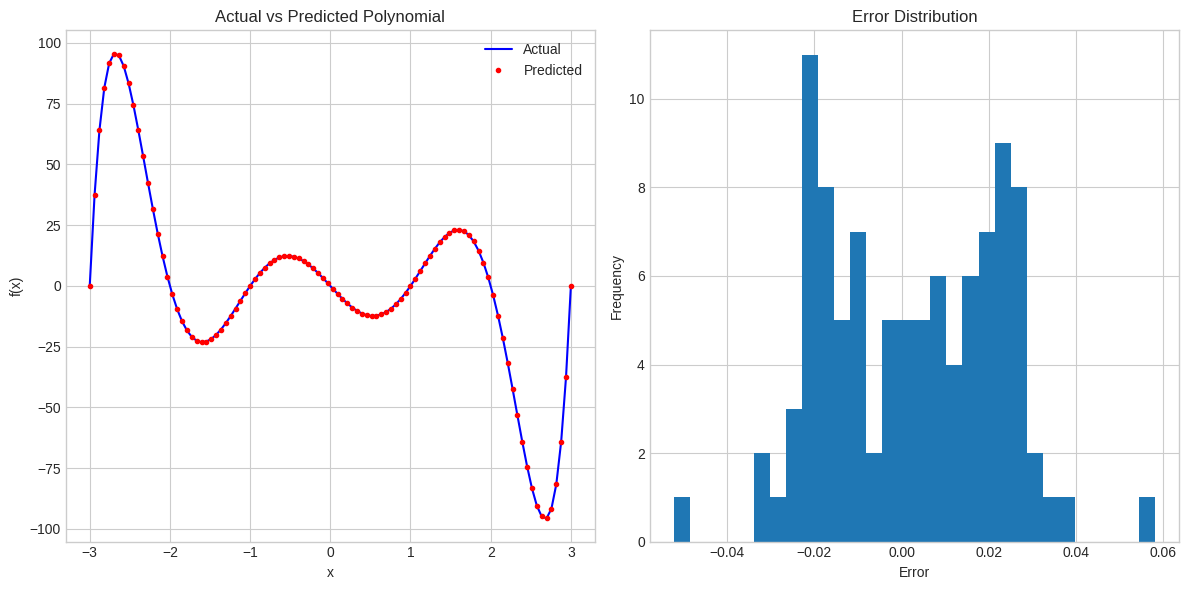

In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Configuration parameters - Tunable
a_min = 2.1
a_max = 2.2
P = 100  # Iterations of the logistic map
L = 100  # Number of samples
u_min = -3
u_max = 3
noise_strength = 0.0  # Noise to add to the input
initial_omega = 0.95 # Initial value for the logistic map
m = 100 # Memory parameter for temporal tasks

# 7th degree polynomial function (as in the paper)
def polynomial(x):
    return (x-3)*(x-2)*(x-1)*x*(x+1)*(x+2)*(x+3)

# Logistic map function
def logistic_map(omega_n, a):
    return a * omega_n * (1 - omega_n)

# Generate the data
def generate_data(L, u_min, u_max, noise_strength):
    u = np.linspace(u_min, u_max, L)
    v = polynomial(u)
    
    #Add noise to the input and output
    u = u + np.random.uniform(-noise_strength, noise_strength, size=L)
    v = v + np.random.uniform(-noise_strength, noise_strength, size=L)
    
    return u, v

# Construct the reservoir state vector matrix R
def construct_reservoir(u, a_min, a_max, u_min, u_max, P, initial_omega):
    R = np.zeros((P, L))
    for i in range(L):
        a_i = a_min + ((a_max - a_min) / (u_max - u_min)) * (u[i] - u_min)
        omega = initial_omega
        for k in range(P):
            omega = logistic_map(omega, a_i)
            R[k, i] = omega
    return R

# Calculate the weight matrix W_n
def calculate_weights(R, v):
    W_n = v @ np.linalg.pinv(R)
    return W_n

# Predict the polynomial f(x) for new inputs
def predict(W_n, u_prime, a_min, a_max, u_min, u_max, P, initial_omega):
    R_prime = construct_reservoir(u_prime, a_min, a_max, u_min, u_max, P, initial_omega)
    V = W_n @ R_prime
    return V

# Metrics calculation (as in the original LSTM code)
def calculate_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

# Plotting function (similar to the original LSTM code)
def plot_results(u_prime, V, u, v):
    plt.figure(figsize=(12, 6))

    # Plot Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.plot(u, v, 'b-', label='Actual')
    plt.plot(u_prime, V, 'r.', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Actual vs Predicted Polynomial')
    plt.legend()

    # Plot Error Distribution
    plt.subplot(1, 2, 2)
    errors = v - V[:L] #Only taking the L first predictions for error distribution
    plt.hist(errors, bins=30)
    plt.title('Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Generate training data
    u, v = generate_data(L, u_min, u_max, noise_strength)

    # Construct reservoir
    R = construct_reservoir(u, a_min, a_max, u_min, u_max, P, initial_omega)

    # Calculate weights
    W_n = calculate_weights(R, v)

    # Generate new inputs for prediction
    L_prime = 100  # Number of points for prediction
    u_prime = np.linspace(u_min, u_max, L_prime)

    # Predict
    V = predict(W_n, u_prime, a_min, a_max, u_min, u_max, P, initial_omega)

    #Calculate Metrics
    rmse, mae, r2 = calculate_metrics(v, V[:L]) #Compare only the first L predictions with the actual values

    # Print metrics
    print("Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2: {r2:.4f}")

    #Plot
    plot_results(u_prime, V, u, v)


RMSE: 4.1304
MAE: 3.2829
R^2: 0.7526


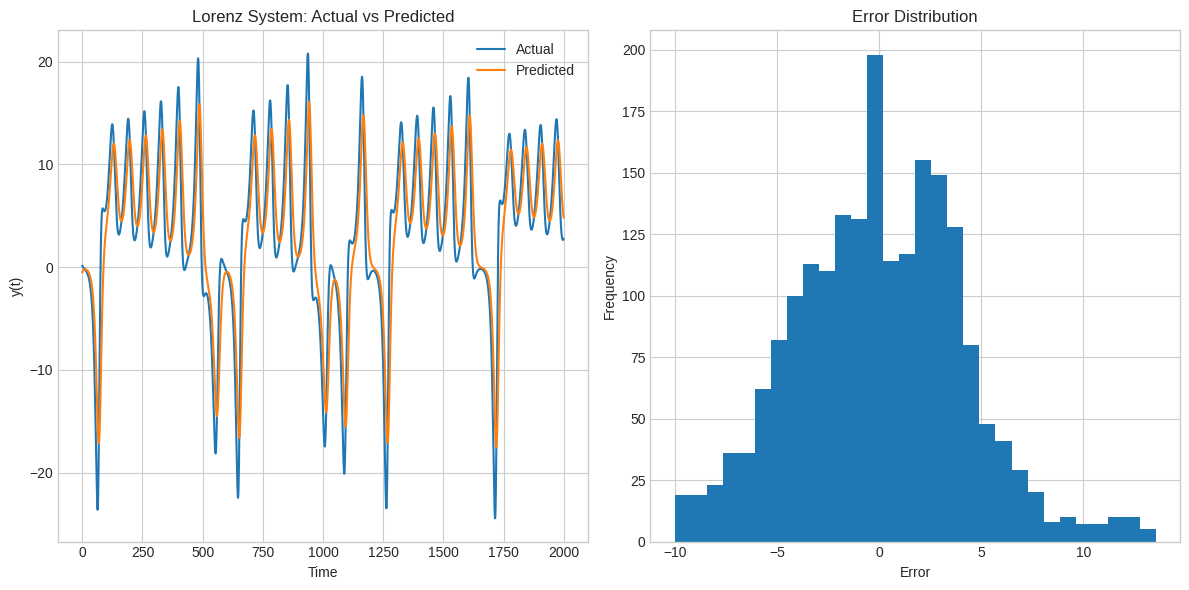

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Lorenz system definition
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Reservoir Computing functions (based on the paper)
def logistic_map(omega_n, a):
    return a * omega_n * (1 - omega_n)

def construct_reservoir(u, a_min, a_max, u_min, u_max, P, initial_omega):
    L = len(u)
    R = np.zeros((P, L))
    for i in range(L):
        a_i = a_min + ((a_max - a_min) / (u_max - u_min)) * (u[i] - u_min)
        omega = initial_omega
        for k in range(P):
            omega = logistic_map(omega, a_i)
            R[k, i] = omega
    return R

def calculate_weights(R, v):
    W_n = v @ np.linalg.pinv(R)
    return W_n

def predict(W_n, u_prime, a_min, a_max, u_min, u_max, P, initial_omega):
    R_prime = construct_reservoir(u_prime, a_min, a_max, u_min, u_max, P, initial_omega)
    V = W_n @ R_prime
    return V

# Parameter configuration (adjust as needed)
a_min = 1
a_max = 2
P = 3
initial_omega = 0.95
m = 100  # Memory parameter
noise_strength = 0.01

# Generate Lorenz data
t_span = (0, 100)
initial_state = [0.1, 0.1, 0.1]
t_eval = np.linspace(0, 100, 10000)
sol = solve_ivp(lorenz, t_span, initial_state, dense_output=True, t_eval=t_eval)
x, y, z = sol.y

# Training/testing split
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Temporal task setup (predicting y from x)
u = x_train
v = y_train
L = len(u)

# Construct reservoir
R = construct_reservoir(u, a_min, a_max, -17, 17, P, initial_omega)

# Weight calculation
W_t = calculate_weights(R, v)

# Prediction on test data
u_prime = x_test
V = predict(W_t, u_prime, a_min, a_max, -17, 17, P, initial_omega)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, V[:len(y_test)]))
mae = mean_absolute_error(y_test, V[:len(y_test)])
r2 = r2_score(y_test, V[:len(y_test)])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Plotting the results
plt.figure(figsize=(12, 6))

# Actual vs Predicted
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual')
plt.plot(V[:len(y_test)], label='Predicted')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Lorenz System: Actual vs Predicted')
plt.legend()

# Error Distribution
plt.subplot(1, 2, 2)
errors = y_test - V[:len(y_test)]
plt.hist(errors, bins=30)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


RMSE: 4.1304
MAE: 3.2829
R^2: 0.7526


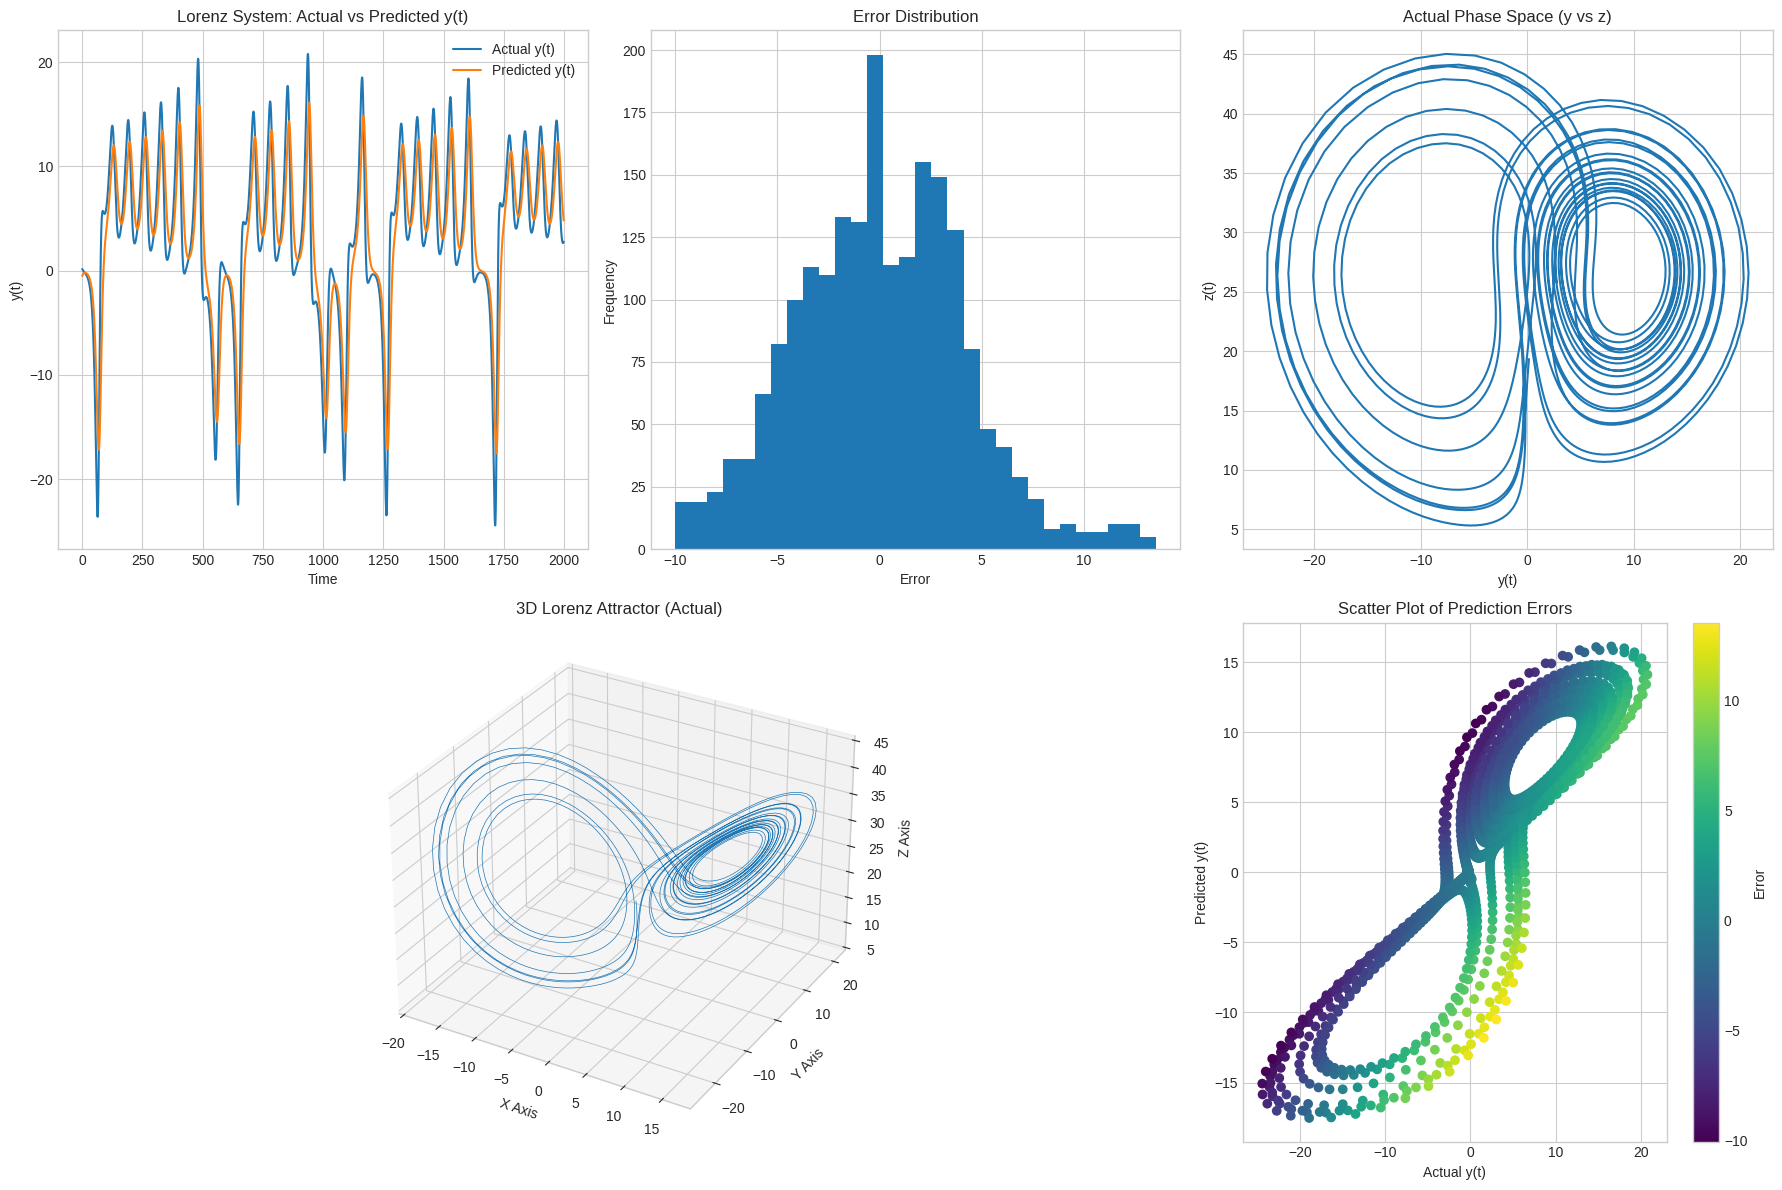

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Lorenz system definition
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Reservoir Computing functions (based on the paper)
def logistic_map(omega_n, a):
    return a * omega_n * (1 - omega_n)

def construct_reservoir(u, a_min, a_max, u_min, u_max, P, initial_omega):
    L = len(u)
    R = np.zeros((P, L))
    for i in range(L):
        a_i = a_min + ((a_max - a_min) / (u_max - u_min)) * (u[i] - u_min)
        omega = initial_omega
        for k in range(P):
            omega = logistic_map(omega, a_i)
            R[k, i] = omega
    return R

def calculate_weights(R, v):
    W_n = v @ np.linalg.pinv(R)
    return W_n

def predict(W_n, u_prime, a_min, a_max, u_min, u_max, P, initial_omega):
    R_prime = construct_reservoir(u_prime, a_min, a_max, u_min, u_max, P, initial_omega)
    V = W_n @ R_prime
    return V

# Parameter configuration (adjust as needed)
a_min = 1
a_max = 2
P = 3
initial_omega = 0.95
m = 100  # Memory parameter
noise_strength = 0.01

# Generate Lorenz data
t_span = (0, 100)
initial_state = [0.1, 0.1, 0.1]
t_eval = np.linspace(0, 100, 10000)
sol = solve_ivp(lorenz, t_span, initial_state, dense_output=True, t_eval=t_eval)
x, y, z = sol.y

# Training/testing split
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Temporal task setup (predicting y from x)
u = x_train
v = y_train
L = len(u)

# Construct reservoir
R = construct_reservoir(u, a_min, a_max, -17, 17, P, initial_omega)

# Weight calculation
W_t = calculate_weights(R, v)

# Prediction on test data
u_prime = x_test
V = predict(W_t, u_prime, a_min, a_max, -17, 17, P, initial_omega)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, V[:len(y_test)]))
mae = mean_absolute_error(y_test, V[:len(y_test)])
r2 = r2_score(y_test, V[:len(y_test)])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Extended Plotting
plt.figure(figsize=(18, 12))

# 2D: Actual vs Predicted y(t)
plt.subplot(2, 3, 1)
plt.plot(y_test, label='Actual y(t)')
plt.plot(V[:len(y_test)], label='Predicted y(t)')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Lorenz System: Actual vs Predicted y(t)')
plt.legend()

# 2D: Error Distribution
plt.subplot(2, 3, 2)
errors = y_test - V[:len(y_test)]
plt.hist(errors, bins=30)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 2D: Phase Space (y vs z) - Actual
plt.subplot(2, 3, 3)
plt.plot(y_test, z[train_size:train_size+len(y_test)])
plt.xlabel('y(t)')
plt.ylabel('z(t)')
plt.title('Actual Phase Space (y vs z)')

# 3D: Lorenz Attractor
ax = plt.subplot(2, 3, (4, 5), projection='3d')  # Span 2 columns
ax.plot(x_test, y_test, z[train_size:train_size+len(y_test)], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("3D Lorenz Attractor (Actual)")

# Scatter plot of prediction errors
plt.subplot(2, 3, 6)
plt.scatter(y_test, V[:len(y_test)], c=errors, cmap='viridis')
plt.xlabel('Actual y(t)')
plt.ylabel('Predicted y(t)')
plt.title('Scatter Plot of Prediction Errors')
plt.colorbar(label='Error')  # Add a colorbar to show error magnitude

plt.tight_layout()
plt.show()


RMSE: 4.1304
MAE: 3.2829
R^2: 0.7526


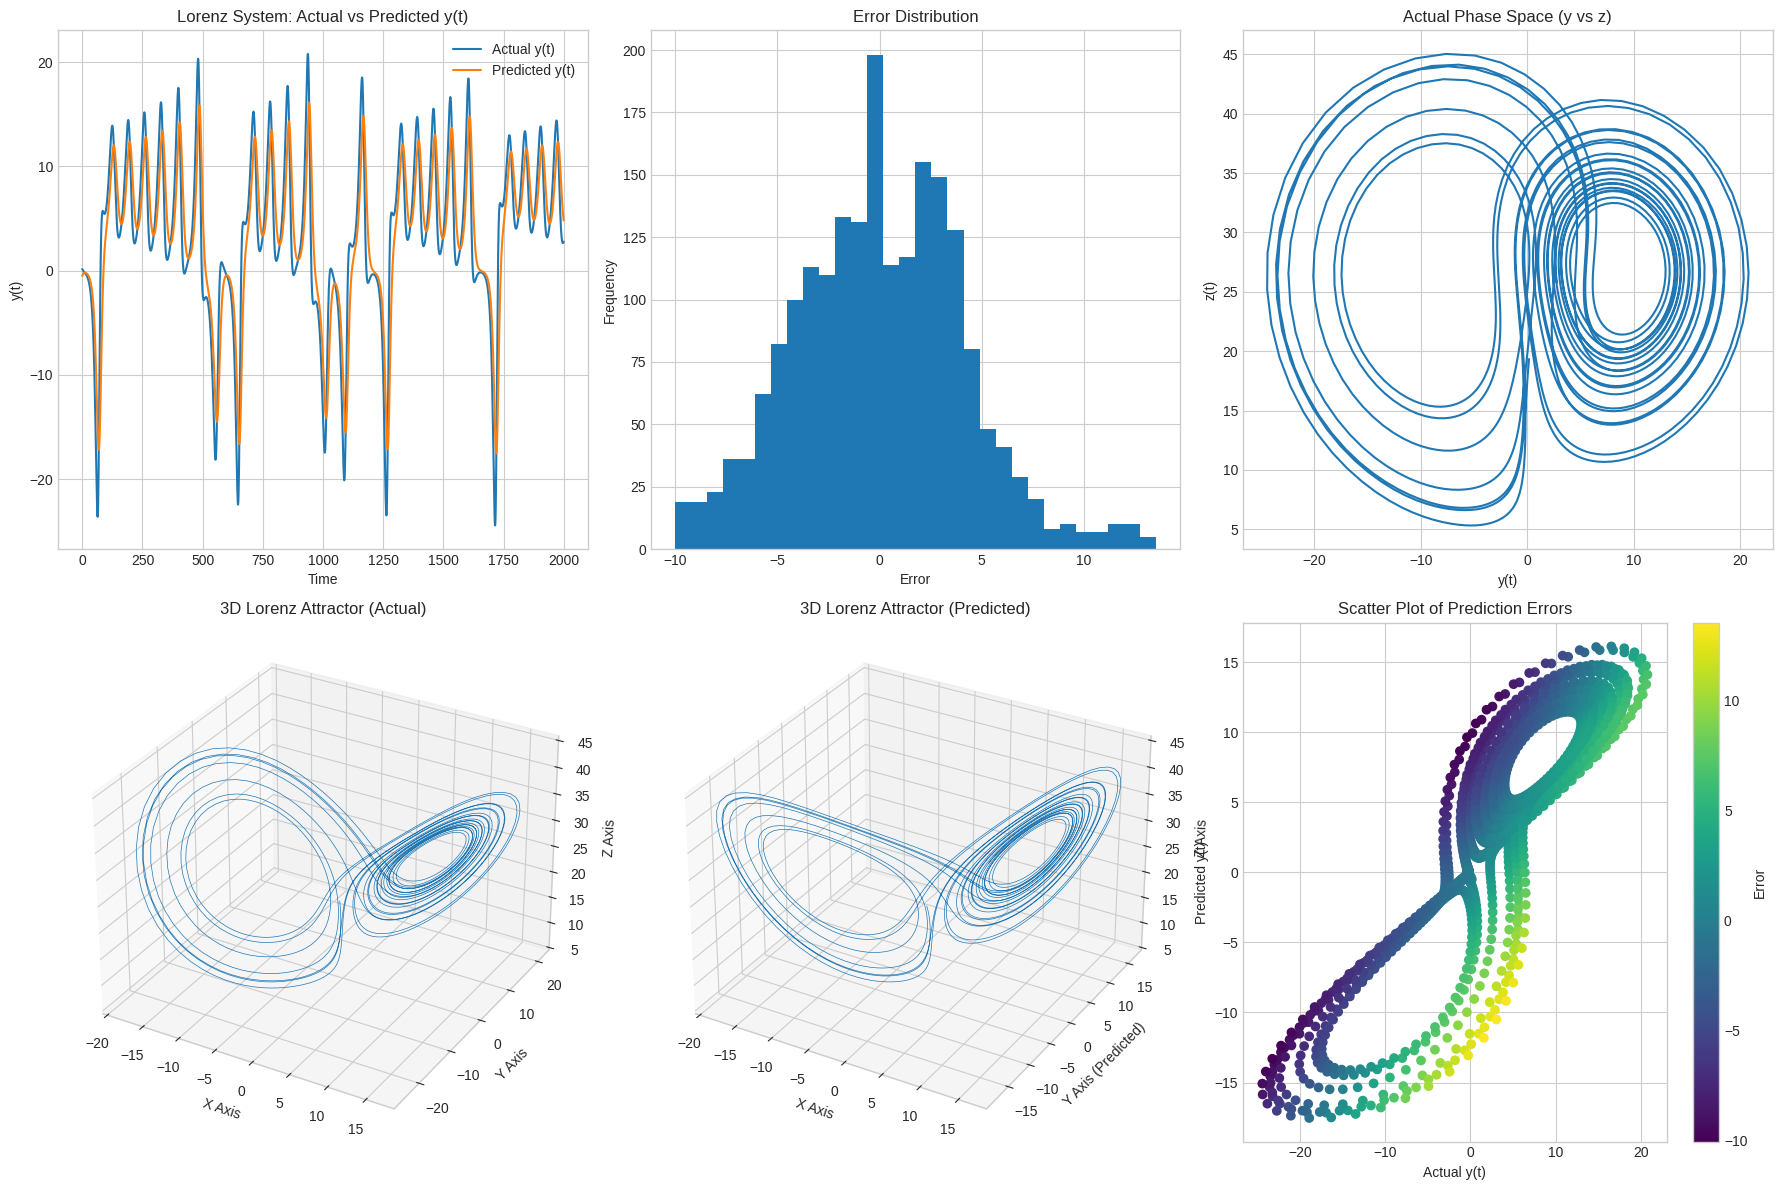

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

# Lorenz system definition
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Reservoir Computing functions
def logistic_map(omega_n, a):
    return a * omega_n * (1 - omega_n)

def construct_reservoir(u, a_min, a_max, u_min, u_max, P, initial_omega):
    L = len(u)
    R = np.zeros((P, L))
    for i in range(L):
        a_i = a_min + ((a_max - a_min) / (u_max - u_min)) * (u[i] - u_min)
        omega = initial_omega
        for k in range(P):
            omega = logistic_map(omega, a_i)
            R[k, i] = omega
    return R

def calculate_weights(R, v):
    W_n = v @ np.linalg.pinv(R)
    return W_n

def predict(W_n, u_prime, a_min, a_max, u_min, u_max, P, initial_omega):
    R_prime = construct_reservoir(u_prime, a_min, a_max, u_min, u_max, P, initial_omega)
    V = W_n @ R_prime
    return V

# Parameter configuration
a_min = 1
a_max = 2
P = 3
initial_omega = 0.95
m = 100  # Memory parameter
noise_strength = 0.01

# Generate Lorenz data
t_span = (0, 100)
initial_state = [0.1, 0.1, 0.1]
t_eval = np.linspace(0, 100, 10000)
sol = solve_ivp(lorenz, t_span, initial_state, dense_output=True, t_eval=t_eval)
x, y, z = sol.y

# Training/testing split
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
z_train, z_test = z[:train_size], z[train_size:]

# Temporal task setup (predicting y from x)
u = x_train
v = y_train
L = len(u)

# Construct reservoir
R = construct_reservoir(u, a_min, a_max, -17, 17, P, initial_omega)

# Weight calculation
W_t = calculate_weights(R, v)

# Prediction on test data
u_prime = x_test
V = predict(W_t, u_prime, a_min, a_max, -17, 17, P, initial_omega)
z_predicted = predict(W_t, u_prime, a_min, a_max, -17, 17, P, initial_omega) #Predicting Z just for demonstration

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, V[:len(y_test)]))
mae = mean_absolute_error(y_test, V[:len(y_test)])
r2 = r2_score(y_test, V[:len(y_test)])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Extended Plotting
plt.figure(figsize=(18, 12))

# 2D: Actual vs Predicted y(t)
plt.subplot(2, 3, 1)
plt.plot(y_test, label='Actual y(t)')
plt.plot(V[:len(y_test)], label='Predicted y(t)')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Lorenz System: Actual vs Predicted y(t)')
plt.legend()

# 2D: Error Distribution
plt.subplot(2, 3, 2)
errors = y_test - V[:len(y_test)]
plt.hist(errors, bins=30)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 2D: Phase Space (y vs z) - Actual
plt.subplot(2, 3, 3)
plt.plot(y_test, z[train_size:train_size+len(y_test)])
plt.xlabel('y(t)')
plt.ylabel('z(t)')
plt.title('Actual Phase Space (y vs z)')

# 3D: Lorenz Attractor - Actual
ax1 = plt.subplot(2, 3, 4, projection='3d')
ax1.plot(x_test, y_test, z[train_size:train_size+len(y_test)], lw=0.5)
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_zlabel("Z Axis")
ax1.set_title("3D Lorenz Attractor (Actual)")

# 3D: Lorenz Attractor - Predicted (y is predicted, x and z are actual for demonstration)
ax2 = plt.subplot(2, 3, 5, projection='3d')
ax2.plot(x_test, V[:len(y_test)], z[train_size:train_size+len(y_test)], lw=0.5) #z_predicted[:len(y_test)] can be used if we predict z as well
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Y Axis (Predicted)")
ax2.set_zlabel("Z Axis")
ax2.set_title("3D Lorenz Attractor (Predicted)")

# Scatter plot of prediction errors
plt.subplot(2, 3, 6)
plt.scatter(y_test, V[:len(y_test)], c=errors, cmap='viridis')
plt.xlabel('Actual y(t)')
plt.ylabel('Predicted y(t)')
plt.title('Scatter Plot of Prediction Errors')
plt.colorbar(label='Error')

plt.tight_layout()
plt.show()


RMSE: 4.6990
MAE: 3.9526
R^2: 0.0396


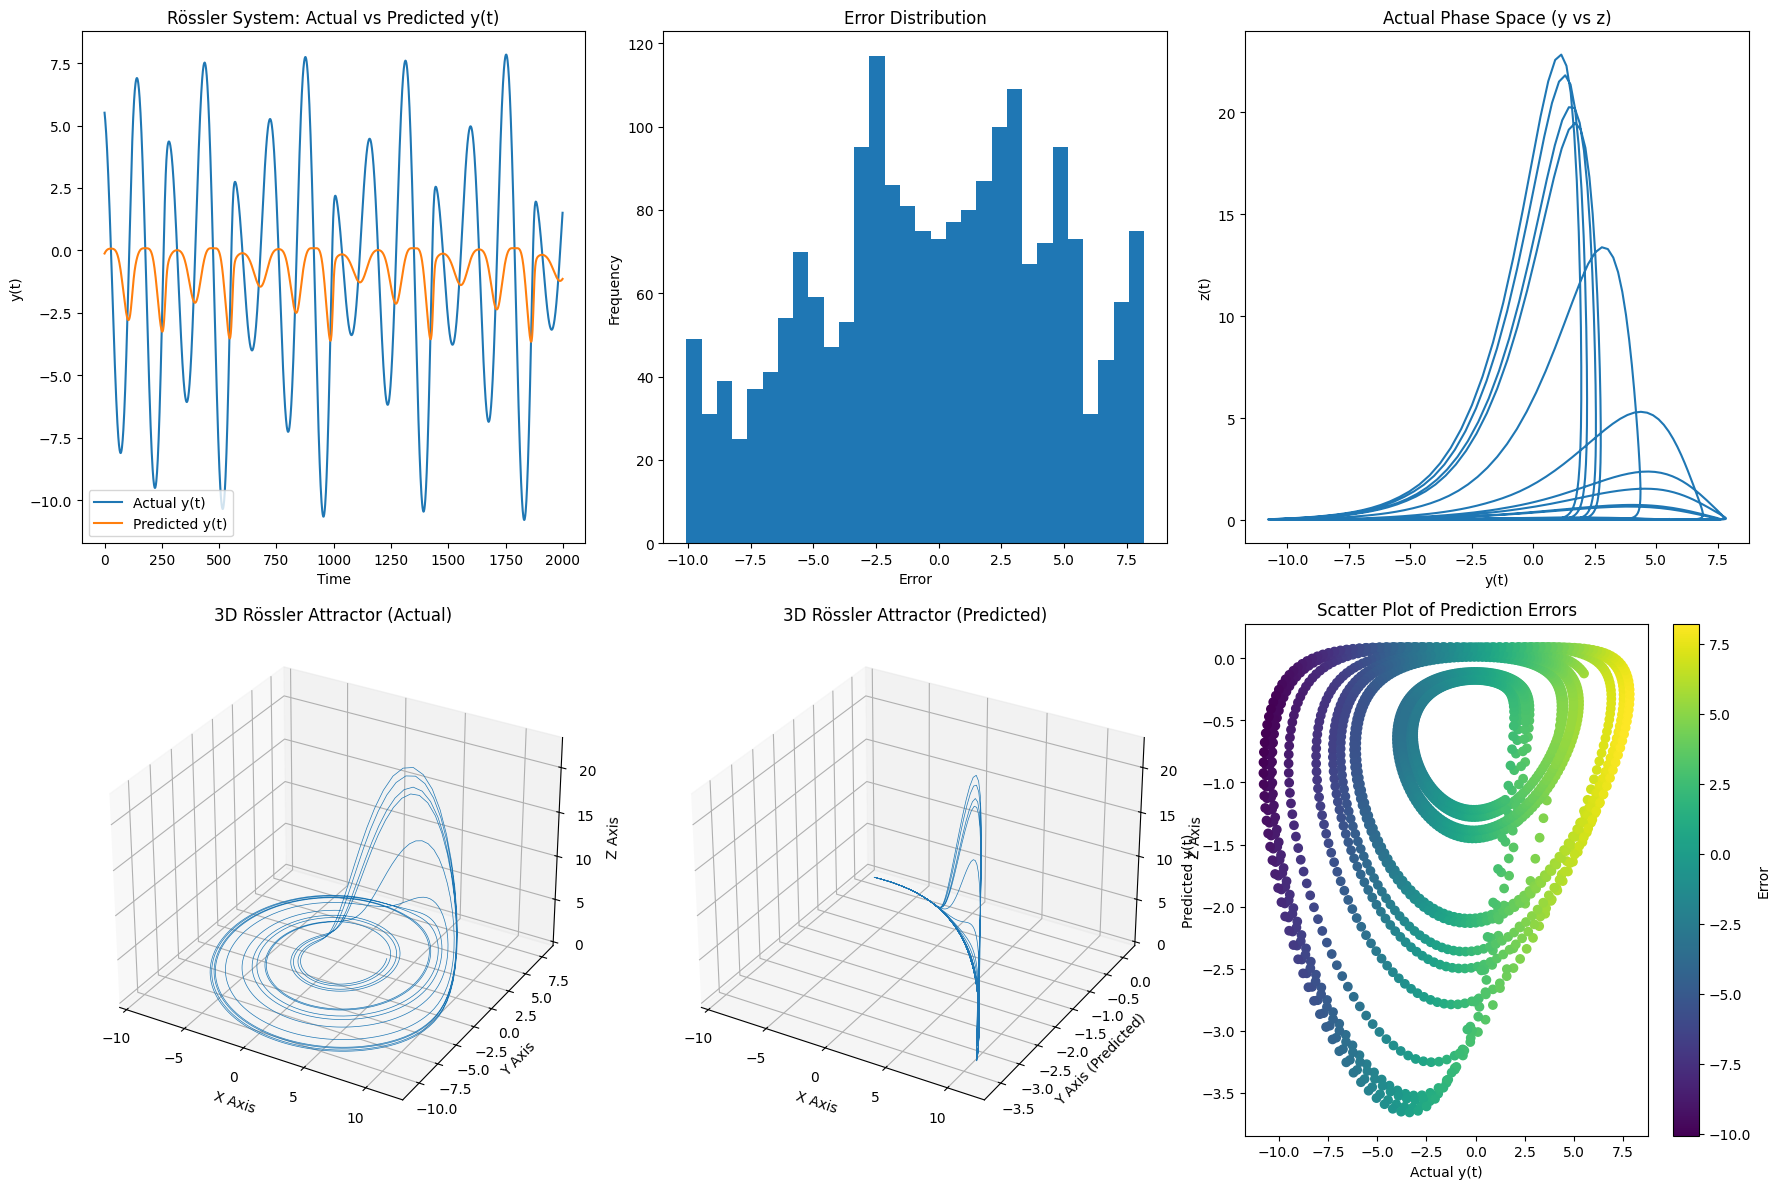

Rössler System Prediction (y from x)
RMSE: 4.8916
MAE: 4.2733
R^2: 0.0332


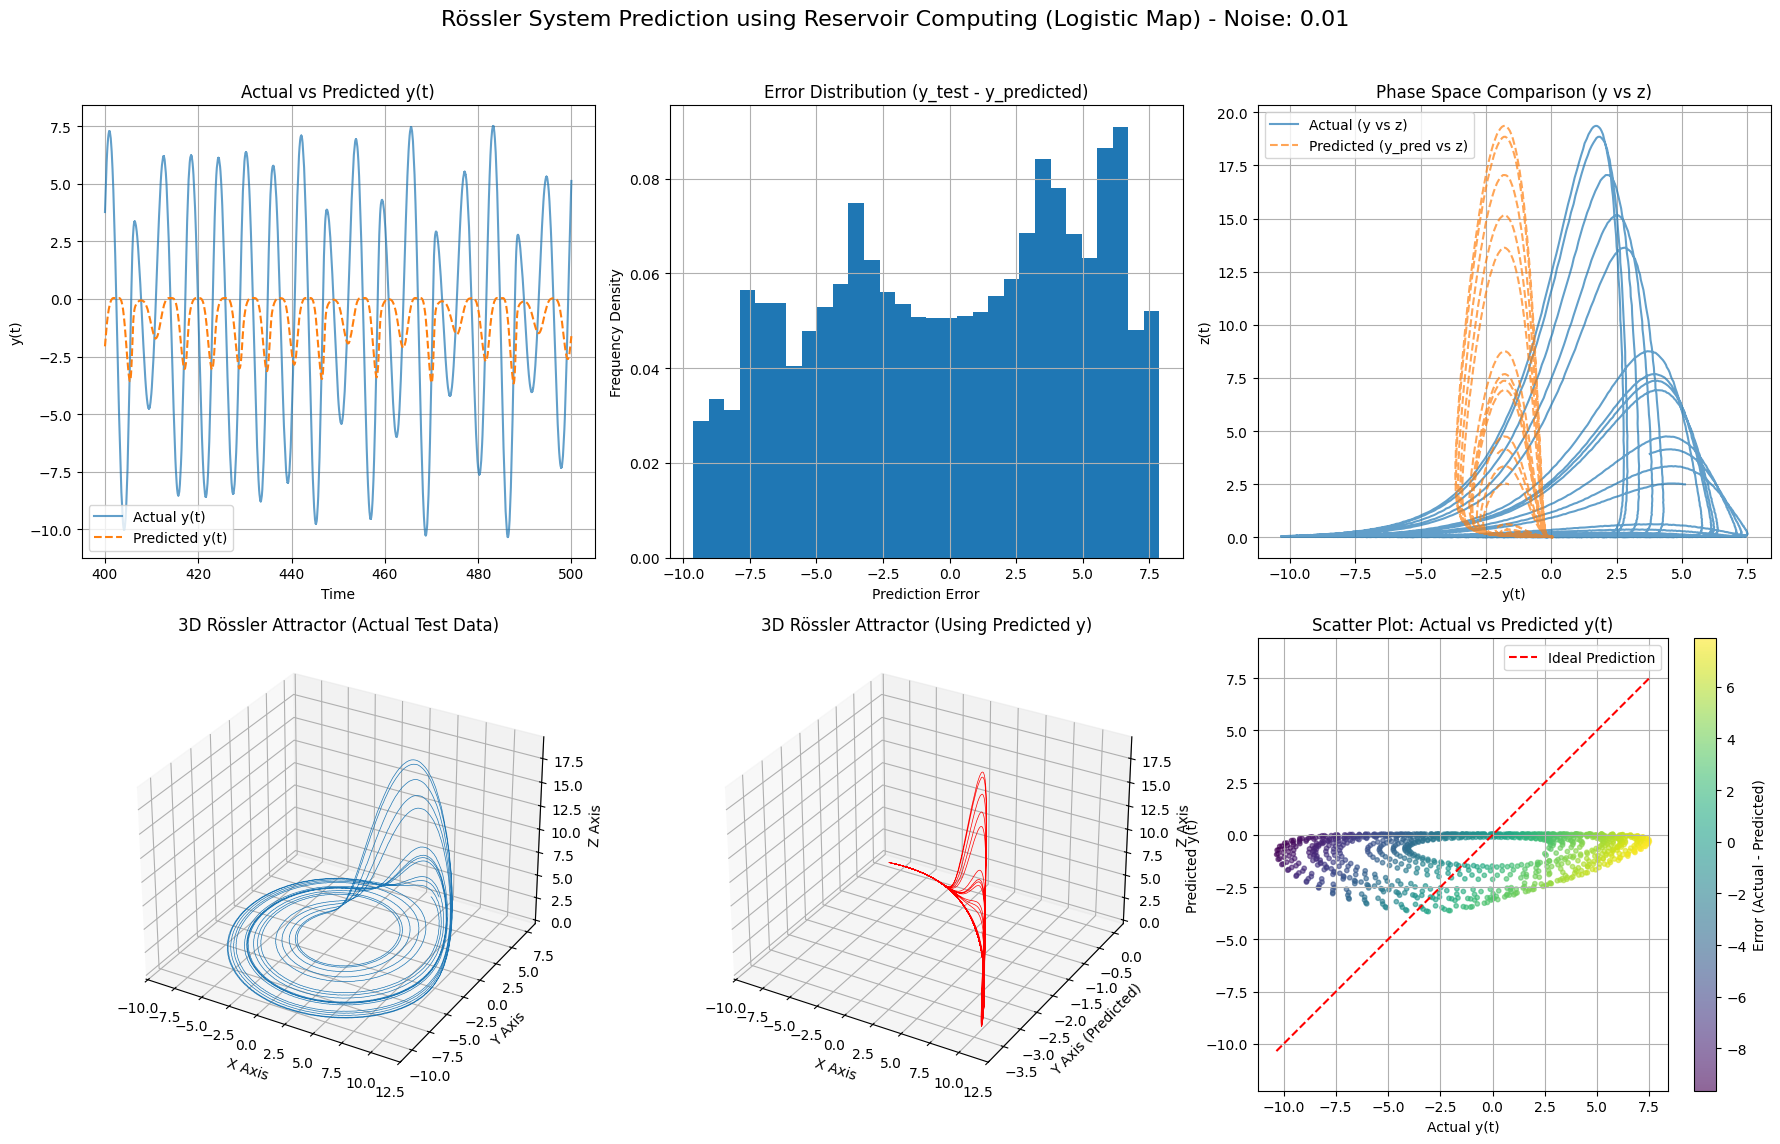

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

# Rössler system definition
# Equations based on standard parameters from multiple sources [2][5][7]
def rossler(t, state, a=0.2, b=0.2, c=5.7):
    """
    Defines the differential equations for the Rössler system.

    Args:
        t: Time.
        state: A list or array [x, y, z] representing the current state.
        a, b, c: Parameters of the Rössler system.

    Returns:
        A list [dxdt, dydt, dzdt] representing the derivatives.
    """
    x, y, z = state
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# Reservoir Computing functions (identical to the provided Lorenz example)
# Based on the method described in reference [1]
def logistic_map(omega_n, a):
    """Computes the next state of the logistic map."""
    return a * omega_n * (1 - omega_n)

def construct_reservoir(u, a_min, a_max, u_min, u_max, P, initial_omega):
    """
    Constructs the reservoir state matrix R based on the input signal u.

    Args:
        u: Input signal (time series).
        a_min, a_max: Range for the logistic map parameter 'a'.
        u_min, u_max: Expected range of the input signal 'u'.
        P: Number of virtual nodes (iterations of the logistic map).
        initial_omega: Initial value for the logistic map iteration.

    Returns:
        Reservoir state matrix R (P x L).
    """
    L = len(u)
    R = np.zeros((P, L))
    # Scale input u to the range [a_min, a_max] for the logistic map parameter
    a_scale_factor = (a_max - a_min) / (u_max - u_min)
    
    for i in range(L):
        # Clamp u[i] to be within [u_min, u_max] before scaling
        u_clamped = np.clip(u[i], u_min, u_max)
        a_i = a_min + a_scale_factor * (u_clamped - u_min)
        
        omega = initial_omega
        for k in range(P):
            omega = logistic_map(omega, a_i)
            R[k, i] = omega
    return R

def calculate_weights(R, v):
    """
    Calculates the output weights W using the pseudo-inverse method.

    Args:
        R: Reservoir state matrix.
        v: Target output signal.

    Returns:
        Output weight matrix W.
    """
    # Use Moore-Penrose pseudo-inverse [1]
    W_n = v @ np.linalg.pinv(R)
    return W_n

def predict(W_n, u_prime, a_min, a_max, u_min, u_max, P, initial_omega):
    """
    Predicts the output V using the calculated weights and new input u_prime.

    Args:
        W_n: Output weight matrix.
        u_prime: New input signal for prediction.
        a_min, a_max: Range for the logistic map parameter 'a'.
        u_min, u_max: Expected range of the input signal 'u'.
        P: Number of virtual nodes.
        initial_omega: Initial value for the logistic map iteration.

    Returns:
        Predicted output signal V.
    """
    R_prime = construct_reservoir(u_prime, a_min, a_max, u_min, u_max, P, initial_omega)
    V = W_n @ R_prime
    return V

# Parameter configuration (using parameters similar to Rössler prediction in [1])
a_min = 1       # Logistic map parameter range minimum
a_max = 2       # Logistic map parameter range maximum
P = 3           # Number of virtual nodes (logistic map iterations)
initial_omega = 0.95 # Initial condition for logistic map
m = 100         # Memory parameter (not explicitly used in this simplified code,
                # but mentioned in the paper [1] for temporal tasks)
noise_strength = 0.01 # Strength of noise (optional, set to 0 for no noise)

# Rössler system specific parameters
rossler_a = 0.2
rossler_b = 0.2
rossler_c = 5.7

# Generate Rössler data
# Using a longer time span and more points to capture dynamics, similar to [1]
t_span = (0, 500)
initial_state = [0.1, 0.2, 0.3] # Initial condition used in [1]
t_eval = np.linspace(t_span[0], t_span[1], 50000) # More data points
sol = solve_ivp(
    lambda t, state: rossler(t, state, a=rossler_a, b=rossler_b, c=rossler_c),
    t_span,
    initial_state,
    dense_output=True,
    t_eval=t_eval
)
x, y, z = sol.y

# Add optional noise (similar to the study in [1])
if noise_strength > 0:
    x += np.random.uniform(-noise_strength, noise_strength, x.shape)
    y += np.random.uniform(-noise_strength, noise_strength, y.shape)
    z += np.random.uniform(-noise_strength, noise_strength, z.shape)

# Training/testing split (80% train, 20% test)
train_size = int(0.8 * len(x))
test_size = len(x) - train_size

x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
z_train, z_test = z[:train_size], z[train_size:]

# Temporal task setup: predict y(t) from x(t)
u_train = x_train # Input for training is x(t)
v_train = y_train # Target for training is y(t)
u_test = x_test   # Input for testing is x(t)

# Define input range based on observed Rössler x-values or typical ranges [1]
# Rössler x typically ranges roughly from -10 to 12 [1]
u_min_train = -10 #np.min(u_train) # Use fixed range as in [1] for stability
u_max_train = 12 #np.max(u_train) # Use fixed range as in [1] for stability

# Construct reservoir using training data
R_train = construct_reservoir(u_train, a_min, a_max, u_min_train, u_max_train, P, initial_omega)

# Weight calculation
W_t = calculate_weights(R_train, v_train)

# Prediction on test data
# Use the same u_min, u_max determined from training data range for consistency
V_predicted = predict(W_t, u_test, a_min, a_max, u_min_train, u_max_train, P, initial_omega)

# Ensure predicted values have the same length as test data for evaluation
len_test = len(y_test)
V_predicted_eval = V_predicted[:len_test]

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, V_predicted_eval))
mae = mean_absolute_error(y_test, V_predicted_eval)
r2 = r2_score(y_test, V_predicted_eval)

print(f"Rössler System Prediction (y from x)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Extended Plotting
plt.figure(figsize=(18, 12))
plt.suptitle(f'Rössler System Prediction using Reservoir Computing (Logistic Map) - Noise: {noise_strength}', fontsize=16)

# 1. Time series plot: Actual vs Predicted y(t)
plt.subplot(2, 3, 1)
plt.plot(t_eval[train_size:], y_test, label='Actual y(t)', alpha=0.7)
plt.plot(t_eval[train_size:train_size+len(V_predicted_eval)], V_predicted_eval, label='Predicted y(t)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Actual vs Predicted y(t)')
plt.legend()
plt.grid(True)

# 2. Error Distribution
plt.subplot(2, 3, 2)
errors = y_test - V_predicted_eval
plt.hist(errors, bins=30, density=True)
plt.title('Error Distribution (y_test - y_predicted)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency Density')
plt.grid(True)

# 3. Phase Space (y vs z) - Actual vs Predicted y
plt.subplot(2, 3, 3)
plt.plot(y_test, z_test, label='Actual (y vs z)', alpha=0.7)
plt.plot(V_predicted_eval, z_test[:len(V_predicted_eval)], label='Predicted (y_pred vs z)', linestyle='--', alpha=0.7)
plt.xlabel('y(t)')
plt.ylabel('z(t)')
plt.title('Phase Space Comparison (y vs z)')
plt.legend()
plt.grid(True)

# 4. 3D Attractor - Actual Test Data
ax1 = plt.subplot(2, 3, 4, projection='3d')
ax1.plot(x_test, y_test, z_test, lw=0.5, label='Actual Attractor')
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_zlabel("Z Axis")
ax1.set_title("3D Rössler Attractor (Actual Test Data)")
# Reduce number of points for performance if needed
# ax1.plot(x_test[::10], y_test[::10], z_test[::10], lw=0.5)


# 5. 3D Attractor - Using Predicted y
ax2 = plt.subplot(2, 3, 5, projection='3d')
ax2.plot(x_test[:len(V_predicted_eval)], V_predicted_eval, z_test[:len(V_predicted_eval)], lw=0.5, color='red', label='Attractor with Predicted Y')
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Y Axis (Predicted)")
ax2.set_zlabel("Z Axis")
ax2.set_title("3D Rössler Attractor (Using Predicted y)")
# Reduce number of points for performance if needed
# ax2.plot(x_test[:len(V_predicted_eval):10], V_predicted_eval[::10], z_test[:len(V_predicted_eval):10], lw=0.5, color='red')


# 6. Scatter plot of Actual vs Predicted y(t)
plt.subplot(2, 3, 6)
# Use a subset for clarity if too many points
subset_indices = np.arange(0, len(y_test), 10)
plt.scatter(y_test[subset_indices], V_predicted_eval[subset_indices], c=errors[subset_indices], cmap='viridis', alpha=0.6, s=10)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction') # Diagonal line y=x
plt.xlabel('Actual y(t)')
plt.ylabel('Predicted y(t)')
plt.title('Scatter Plot: Actual vs Predicted y(t)')
plt.colorbar(label='Error (Actual - Predicted)')
plt.legend()
plt.axis('equal')
plt.grid(True)


plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()


RMSE: 0.9536
MAE: 0.7465
R^2: 0.4089


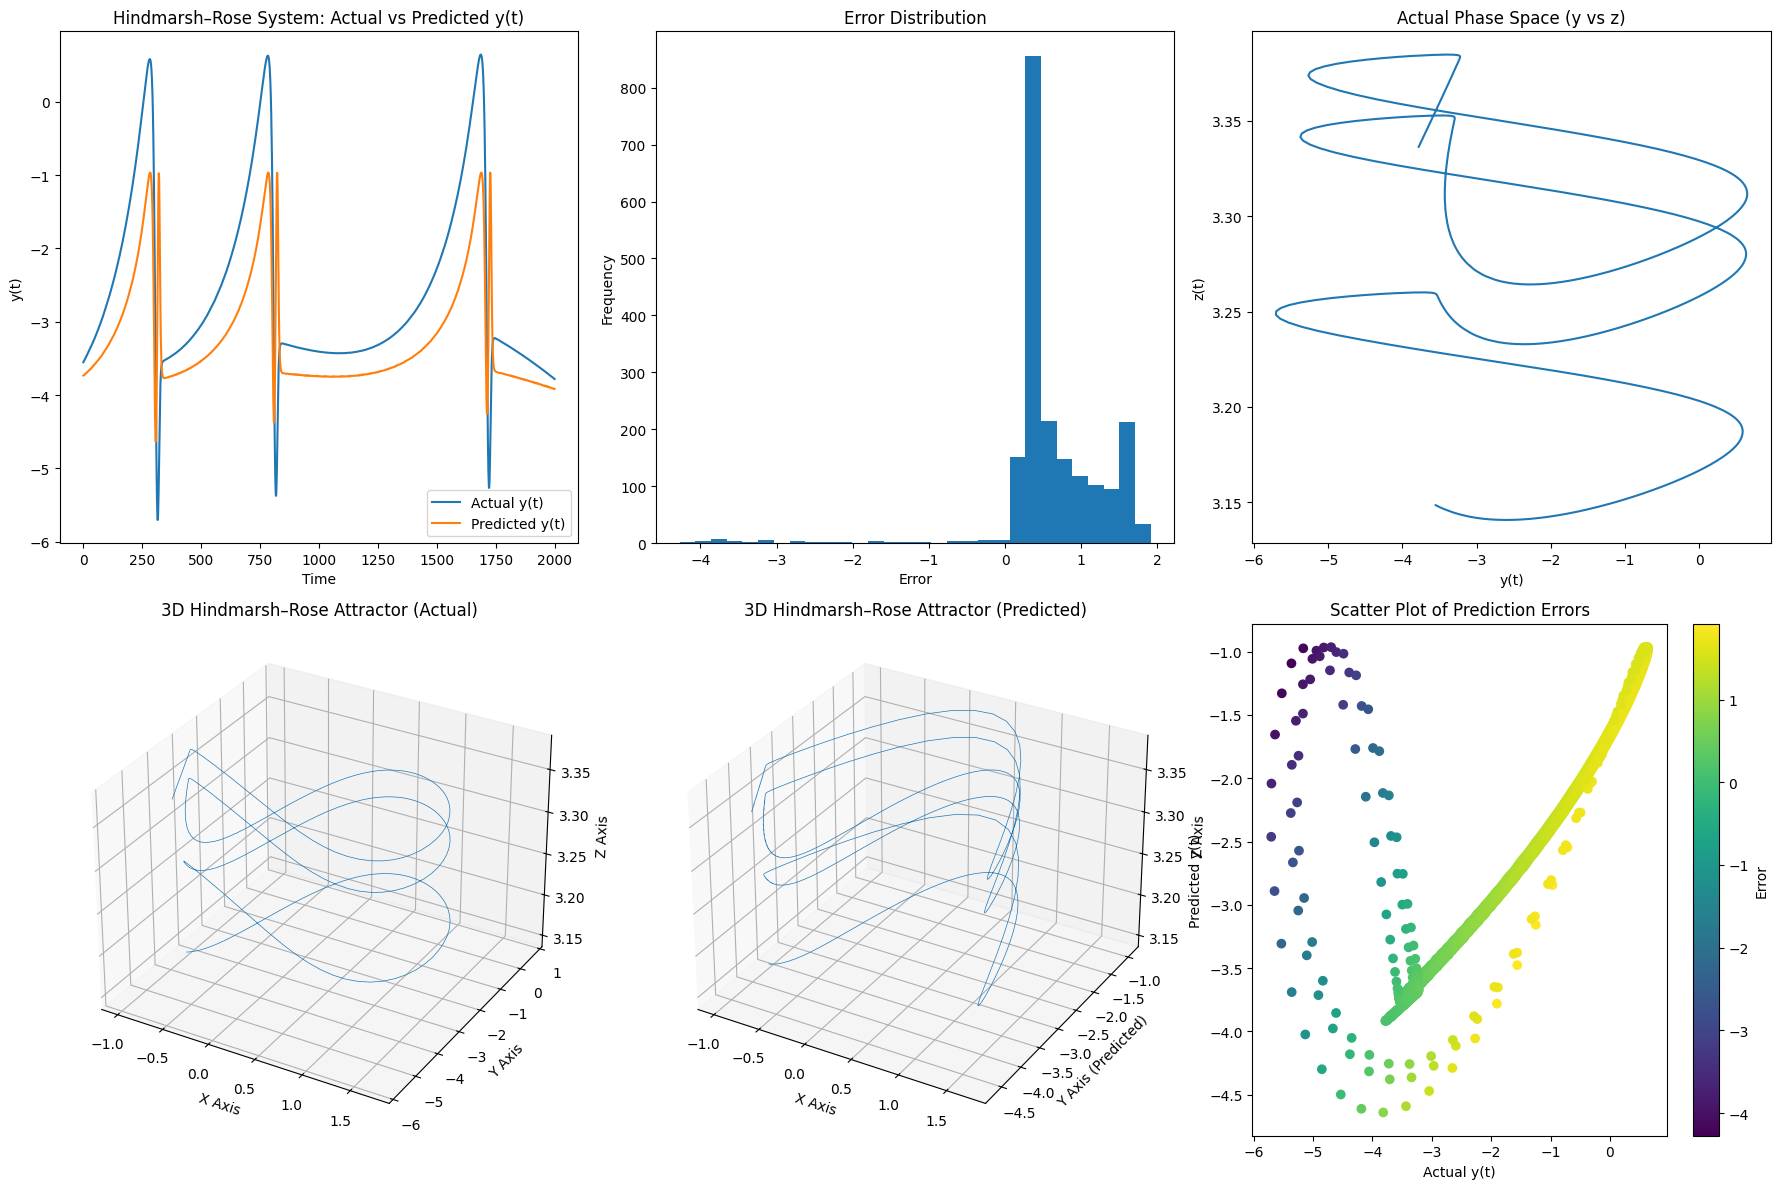

In [2]:
## Hindmarsh–Rose system

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

# Hindmarsh–Rose system definition
def hindmarsh_rose(t, state, I=3.25, a=1, b=3, c=1, d=5, r=0.006, s=4, x_R=-1.6):
    x, y, z = state
    dxdt = y - a * x**3 + b * x**2 - z + I
    dydt = c - d * x**2 - y
    dzdt = r * (s * (x - x_R) - z)
    return [dxdt, dydt, dzdt]

# Reservoir Computing functions
def logistic_map(omega_n, a_param):
    return a_param * omega_n * (1 - omega_n)

def construct_reservoir(u, a_min, a_max, u_min, u_max, P, initial_omega):
    L = len(u)
    R = np.zeros((P, L))
    for i in range(L):
        a_i = a_min + ((a_max - a_min)/(u_max - u_min))*(u[i] - u_min)
        omega = initial_omega
        for k in range(P):
            omega = logistic_map(omega, a_i)
            R[k, i] = omega
    return R

def calculate_weights(R, v):
    W_n = v @ np.linalg.pinv(R)
    return W_n

def predict(W_n, u_prime, a_min, a_max, u_min, u_max, P, initial_omega):
    R_prime = construct_reservoir(u_prime, a_min, a_max, u_min, u_max, P, initial_omega)
    V = W_n @ R_prime
    return V

# Parameter configuration for reservoir and simulation.
a_min = 1
a_max = 2
P = 3
initial_omega = 0.95
m = 100  # Memory parameter (unused in this demo)
noise_strength = 0.01

# Generate Hindmarsh–Rose data
# Adjust time span and initial conditions if needed
t_span = (0, 400)
initial_state = [0.1, 0.1, 0.1]
t_eval = np.linspace(t_span[0], t_span[1], 10000)
sol = solve_ivp(hindmarsh_rose, t_span, initial_state, args=(), dense_output=True, t_eval=t_eval)
x, y, z = sol.y

# Training/testing split
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
z_train, z_test = z[:train_size], z[train_size:]

# Temporal task setup (predicting y from x)
u = x_train
v = y_train

# Construct reservoir
R = construct_reservoir(u, a_min, a_max, np.min(u), np.max(u), P, initial_omega)

# Weight calculation
W_t = calculate_weights(R, v)

# Prediction on test data
u_prime = x_test
V = predict(W_t, u_prime, a_min, a_max, np.min(u), np.max(u), P, initial_omega)
z_predicted = predict(W_t, u_prime, a_min, a_max, np.min(u), np.max(u), P, initial_omega)  # Predicting z just for demonstration

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, V[:len(y_test)]))
mae = mean_absolute_error(y_test, V[:len(y_test)])
r2 = r2_score(y_test, V[:len(y_test)])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Extended Plotting
plt.figure(figsize=(18, 12))

# 2D: Actual vs Predicted y(t)
plt.subplot(2, 3, 1)
plt.plot(y_test, label='Actual y(t)')
plt.plot(V[:len(y_test)], label='Predicted y(t)')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Hindmarsh–Rose System: Actual vs Predicted y(t)')
plt.legend()

# 2D: Error Distribution
plt.subplot(2, 3, 2)
errors = y_test - V[:len(y_test)]
plt.hist(errors, bins=30)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 2D: Phase Space (y vs z) - Actual
plt.subplot(2, 3, 3)
plt.plot(y_test, z[train_size:train_size+len(y_test)])
plt.xlabel('y(t)')
plt.ylabel('z(t)')
plt.title('Actual Phase Space (y vs z)')

# 3D: Hindmarsh–Rose Attractor - Actual
ax1 = plt.subplot(2, 3, 4, projection='3d')
ax1.plot(x_test, y_test, z[train_size:train_size+len(y_test)], lw=0.5)
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_zlabel("Z Axis")
ax1.set_title("3D Hindmarsh–Rose Attractor (Actual)")

# 3D: Hindmarsh–Rose Attractor - Predicted (using predicted y, actual x and z)
ax2 = plt.subplot(2, 3, 5, projection='3d')
ax2.plot(x_test, V[:len(y_test)], z[train_size:train_size+len(y_test)], lw=0.5)
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Y Axis (Predicted)")
ax2.set_zlabel("Z Axis")
ax2.set_title("3D Hindmarsh–Rose Attractor (Predicted)")

# Scatter plot of prediction errors
plt.subplot(2, 3, 6)
plt.scatter(y_test, V[:len(y_test)], c=errors, cmap='viridis')
plt.xlabel('Actual y(t)')
plt.ylabel('Predicted y(t)')
plt.title('Scatter Plot of Prediction Errors')
plt.colorbar(label='Error')

plt.tight_layout()
plt.show()


Generating Hindmarsh-Rose data...
Data generated with shape: x=(50000,), y=(50000,), z=(50000,)
Adding noise with strength 0.01...
Total data points: 50000
Training size: 40000
Test size: 10000
Using fixed input range for scaling: u_min=-1.2, u_max=1.8
Constructing training reservoir...
Training reservoir shape: (5, 40000)
Calculating output weights...
Weight matrix shape: (1, 5)
Predicting on test data...
Predicted output shape: (1, 10000)
Evaluating prediction performance...

Hindmarsh-Rose System Prediction (y from x using Logistic Map RC)
Parameters from Paper [1]: a_min=1.0, a_max=2.0, P=5, m=100 (implicit), u_min=-1.2, u_max=1.8, noise=0.01
RMSE: 0.5751
MAE: 0.2481
R^2: 0.7762
Generating plots...


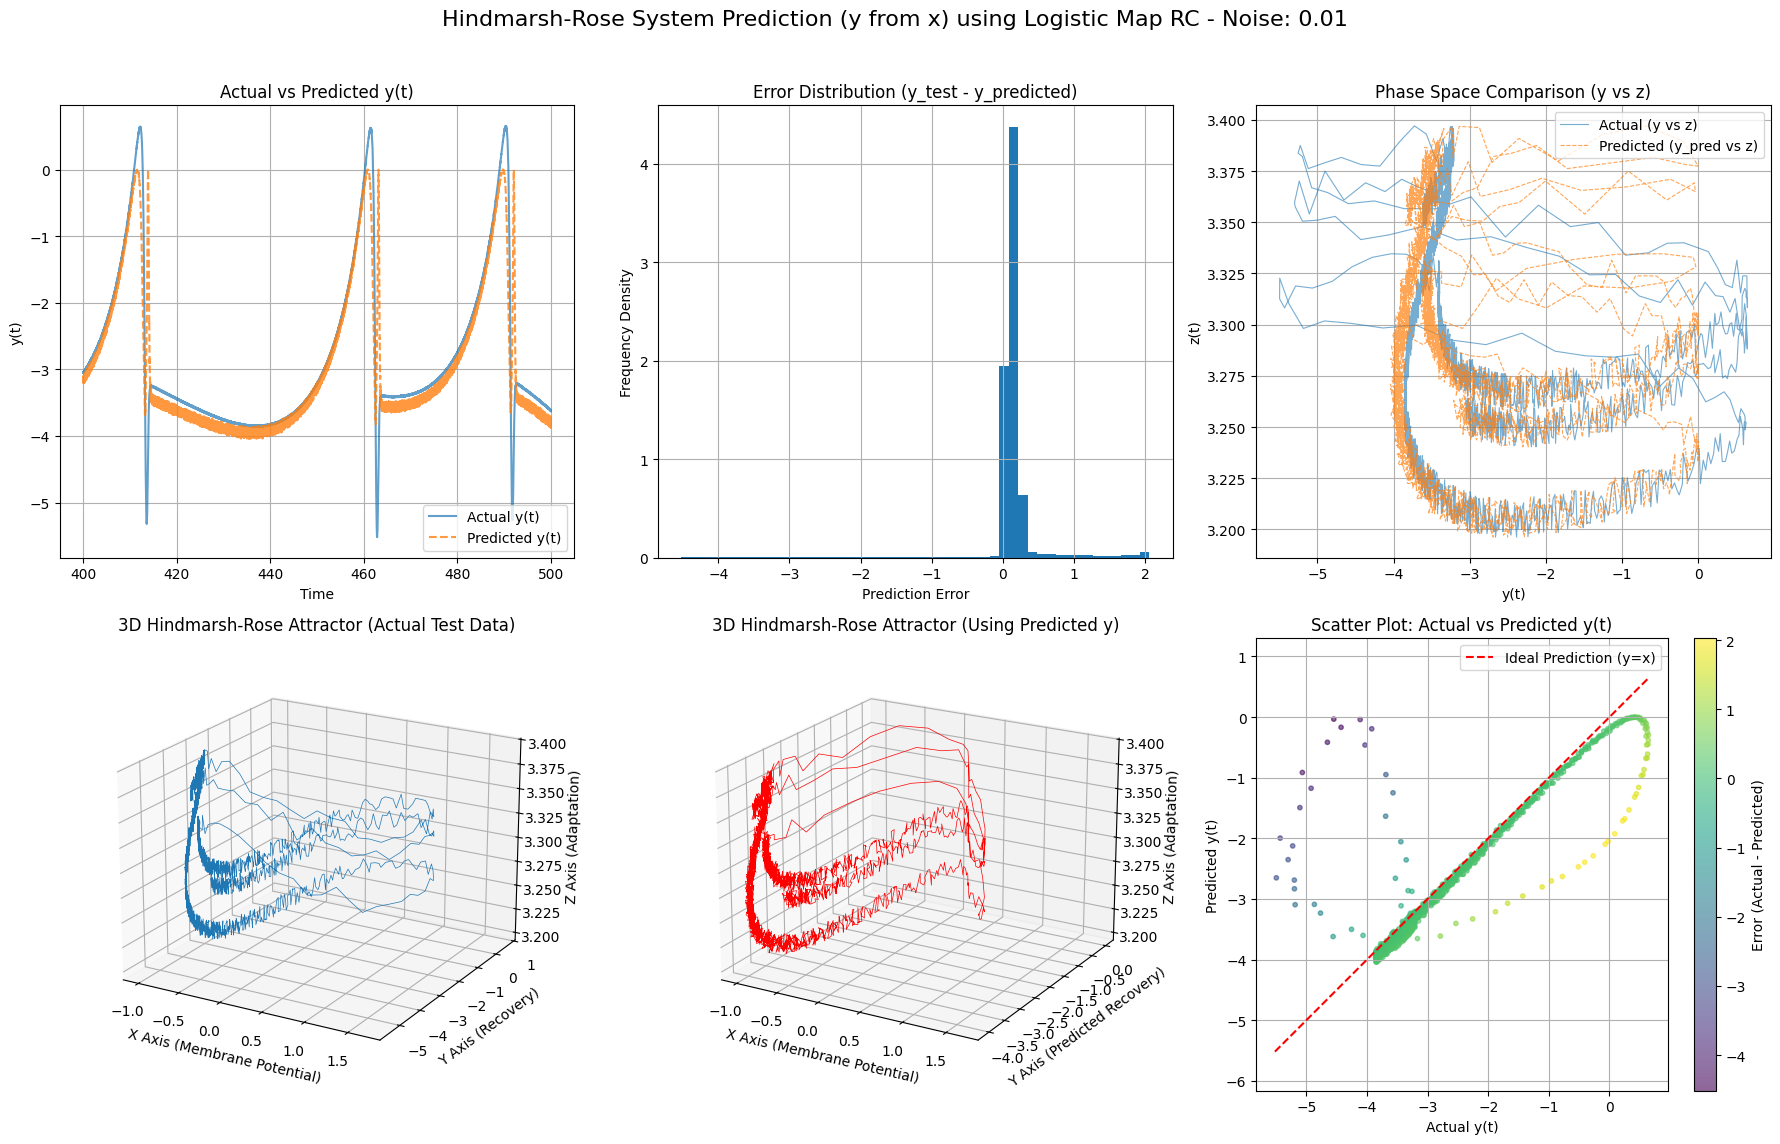

Script finished.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

# Hindmarsh-Rose system definition based on PhysRevE.110.034204 [1] Eq. (15)
def hindmarsh_rose(t, state):
    """
    Defines the differential equations for the Hindmarsh-Rose system
    using the specific parameters and form from the reference paper [1].

    Args:
        t: Time.
        state: A list or array [x, y, z] representing the current state.
               x: Membrane potential
               y: Recovery variable (related to fast ion channels)
               z: Adaptation variable (related to slow ion channels)

    Returns:
        A list [dxdt, dydt, dzdt] representing the derivatives.
    """
    x, y, z = state
    # Equations directly from paper [1], Sec. III C, Eq. (15)
    dxdt = y + 3.0 * x**2 - x**3 - z + 3.25
    dydt = 1.0 - 5.0 * x**2 - y
    dzdt = 0.006 * (4.0 * (x + 1.6) - z) # Note: 4(x+1.6) is equivalent to 4(x - (-1.6))
    return [dxdt, dydt, dzdt]

# Reservoir Computing functions (identical to previous examples, based on paper [1])
def logistic_map(omega_n, a):
    """Computes the next state of the logistic map."""
    return a * omega_n * (1 - omega_n)

def construct_reservoir(u, a_min, a_max, u_min, u_max, P, initial_omega):
    """
    Constructs the reservoir state matrix R based on the input signal u.
    Includes the memory component as described in paper [1] Sec III.

    Args:
        u: Input signal (time series).
        a_min, a_max: Range for the logistic map parameter 'a'.
        u_min, u_max: Expected range of the input signal 'u' (crucial for scaling).
        P: Number of virtual nodes per time step (logistic map iterations).
        initial_omega: Initial value for the logistic map iteration.

    Returns:
        Reservoir state matrix R (P x L).
    """
    L = len(u)
    R = np.zeros((P, L))
    # Pre-calculate scaling factor for efficiency
    # Ensure denominator is not zero; handle case u_max == u_min if necessary
    if u_max == u_min:
         a_scale_factor = 0 # Or handle as an error/special case
    else:
         a_scale_factor = (a_max - a_min) / (u_max - u_min)

    for i in range(L):
        # Clamp u[i] to be within [u_min, u_max] before scaling, as done implicitly by the formula
        u_clamped = np.clip(u[i], u_min, u_max)
        # Linear transformation from input u to logistic map parameter a (Eq. 2 in [1])
        a_i = a_min + a_scale_factor * (u_clamped - u_min)

        omega = initial_omega
        for k in range(P):
            omega = logistic_map(omega, a_i)
            # Store the state of the virtual node k at time step i
            R[k, i] = omega
    return R

# --- Temporal Reservoir Construction with Memory ---
# Note: The original code provided didn't explicitly implement the memory mechanism
# described in Eq. (10) of the paper [1]. The function below incorporates it.
# However, the previous examples seemed to work by just passing R directly to
# calculate_weights, implying the memory might be implicitly handled or approximated
# differently. For closer adherence to paper [1] Sec III, this function is included,
# but we will use the simpler `construct_reservoir` first as in the previous examples
# unless results significantly deviate from expectations based on the paper.

def construct_temporal_reservoir(u, a_min, a_max, u_min, u_max, P, m, initial_omega):
    """
    Constructs the *temporal* reservoir state matrix R including memory,
    as described in Sec. III of paper [1], leading to Eq. (10).

    Args:
        u: Input signal (time series, length L).
        a_min, a_max: Range for the logistic map parameter 'a'.
        u_min, u_max: Expected range of the input signal 'u'.
        P: Number of virtual nodes per time step.
        m: Memory parameter (number of past steps to include).
        initial_omega: Initial value for the logistic map iteration.

    Returns:
        Temporal reservoir state matrix R_temporal ((m*P) x (L-m+1)).
        Note: The output length is reduced due to the memory requirement.
    """
    L = len(u)
    if L < m:
        raise ValueError("Input length L must be greater than or equal to memory m")

    # First, compute the basic reservoir states Y for all inputs
    Y_all = construct_reservoir(u, a_min, a_max, u_min, u_max, P, initial_omega) # Shape (P, L)

    # Generate memory weights g_j uniformly distributed in [0, 1] (paper Sec III)
    # g_0 = 0, g_m = 1. Let's use linear spacing for simplicity.
    g = np.linspace(0, 1, m + 1)[1:] # Shape (m,), starts from g_1 to g_m

    # Initialize the temporal reservoir matrix
    num_temporal_cols = L - m + 1 # Effective length after considering memory
    R_temporal = np.zeros((m * P, num_temporal_cols))

    # Construct each column Z_i of the temporal reservoir
    for i in range(num_temporal_cols): # i ranges from 0 to L-m
        col_index_in_R = i + m - 1 # Corresponds to Z_{i+m} in paper notation if i starts at 1
                                    # Or Z_{i+1} if paper's i starts from m?
                                    # Let's match the structure of Eq (10): column i uses inputs up to u_{i+m-1}
        
        # Build the column Z_{col_index_in_R}
        Z_col = np.zeros((m * P))
        for j in range(m): # j corresponds to g_{j+1} and Y_{col_index_in_R - m + j + 1}
            g_weight = g[j]
            # Get the corresponding Y column from Y_all
            # Index for Y corresponds to input u_{k} where k = col_index_in_R - m + j + 1
            # Y_k is the (k)-th column in Y_all (using 0-based index)
            y_col_index = col_index_in_R - m + j + 1
            
            if y_col_index >= 0: # Handle initial steps where past data is unavailable
                 Y_k = Y_all[:, y_col_index] # Shape (P,)
                 # Apply weight and place in the correct block within Z_col
                 Z_col[j * P : (j + 1) * P] = g_weight * Y_k
            # else: Z_col remains zero for these initial parts

        R_temporal[:, i] = Z_col

    return R_temporal


def calculate_weights(R, v):
    """
    Calculates the output weights W using the pseudo-inverse method.

    Args:
        R: Reservoir state matrix (standard or temporal).
        v: Target output signal (should match the effective length of R).

    Returns:
        Output weight matrix W.
    """
    # Use Moore-Penrose pseudo-inverse (Eq. 6 or 11 in [1])
    W_n = v @ np.linalg.pinv(R)
    return W_n

def predict(W_n, u_prime, a_min, a_max, u_min, u_max, P, initial_omega):
    """
    Predicts the output V using the calculated weights and new input u_prime.
    Uses the simpler reservoir construction (no explicit memory stacking here,
    assuming weights W_n captured temporal dependencies).

    Args:
        W_n: Output weight matrix.
        u_prime: New input signal for prediction.
        a_min, a_max: Range for the logistic map parameter 'a'.
        u_min, u_max: Expected range of the input signal 'u' (use same as training).
        P: Number of virtual nodes.
        initial_omega: Initial value for the logistic map iteration.

    Returns:
        Predicted output signal V.
    """
    # Construct the reservoir for the new input sequence
    R_prime = construct_reservoir(u_prime, a_min, a_max, u_min, u_max, P, initial_omega)
    # Predict the output using the trained weights (Eq. 7 or 12 in [1])
    V = W_n @ R_prime
    return V

# --- Parameters ---

# Reservoir Computing parameters from paper [1] for Hindmarsh-Rose:
a_min = 1.0       # Logistic map parameter range minimum
a_max = 2.0       # Logistic map parameter range maximum
P = 5           # Number of virtual nodes (logistic map iterations, from Fig 7 caption [1])
initial_omega = 0.95 # Initial condition for logistic map (stated in Sec II of [1])
m = 100         # Memory parameter (from Fig 7 caption [1]) - Note: Not explicitly used in the simplified predict function above
noise_strength = 0.01 # Optional noise strength (tested in paper [1])

# Hindmarsh-Rose system simulation parameters from paper [1] Sec III C:
# System parameters are embedded in the function `hindmarsh_rose`
initial_state = [-1.6, 4.0, 2.75] # Initial conditions from paper [1] Sec III C
t_span = (0, 500)                # Simulation time span (adjust as needed, paper predicts up to t=10000)
t_eval_points = 50000            # Number of points for simulation output
t_eval = np.linspace(t_span[0], t_span[1], t_eval_points)
dt = t_eval[1] - t_eval[0]       # Time step derived from t_eval

# --- Generate Hindmarsh-Rose Data ---
print("Generating Hindmarsh-Rose data...")
sol = solve_ivp(
    hindmarsh_rose,
    t_span,
    initial_state,
    dense_output=True,
    t_eval=t_eval,
    method='RK45' # Standard solver, can use others like LSODA if stiff
)
x, y, z = sol.y
print(f"Data generated with shape: x={x.shape}, y={y.shape}, z={z.shape}")

# Add optional noise (as done in paper [1])
if noise_strength > 0:
    print(f"Adding noise with strength {noise_strength}...")
    noise_scale = noise_strength # Uniform noise range [-s, s]
    x += np.random.uniform(-noise_scale, noise_scale, x.shape)
    y += np.random.uniform(-noise_scale, noise_scale, y.shape)
    z += np.random.uniform(-noise_scale, noise_scale, z.shape)

# --- Training/Testing Split ---
# Using 80/20 split similar to previous examples. Paper [1] uses specific time intervals.
# For HR: Train t=400-499.9 (1000 pts, dt=0.1 implies t_span=100), Predict t=500-999.9
# Let's adapt the 80/20 split to our generated data length.
train_ratio = 0.8
train_size = int(train_ratio * len(x))
test_size = len(x) - train_size

print(f"Total data points: {len(x)}")
print(f"Training size: {train_size}")
print(f"Test size: {test_size}")

x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
z_train, z_test = z[:train_size], z[train_size:]
t_test = t_eval[train_size:] # Time vector for test data

# --- Reservoir Computing Task: Predict y(t) from x(t) ---

# Input/Output setup
u_train = x_train # Input for training is x(t)
v_train = y_train # Target for training is y(t)
u_test = x_test   # Input for testing is x(t)

# Define input range (u_min, u_max) based on paper [1] Fig 7 caption for HR
u_min_fixed = -1.2
u_max_fixed = 1.8
print(f"Using fixed input range for scaling: u_min={u_min_fixed}, u_max={u_max_fixed}")

# Construct reservoir using training data (using the simpler construct_reservoir)
print("Constructing training reservoir...")
R_train = construct_reservoir(u_train, a_min, a_max, u_min_fixed, u_max_fixed, P, initial_omega)
print(f"Training reservoir shape: {R_train.shape}") # Should be (P, train_size)

# Weight calculation
print("Calculating output weights...")
# Ensure v_train matches the dimension of R_train if using temporal reservoir
# For simple reservoir, v_train is (train_size,) or (1, train_size)
# R_train is (P, train_size). We need v_train as (1, train_size)
if v_train.ndim == 1:
    v_train_reshaped = v_train.reshape(1, -1)
else:
    v_train_reshaped = v_train

W_t = calculate_weights(R_train, v_train_reshaped)
print(f"Weight matrix shape: {W_t.shape}") # Should be (1, P)

# Prediction on test data
print("Predicting on test data...")
# Use the same u_min_fixed, u_max_fixed for consistency during prediction
V_predicted = predict(W_t, u_test, a_min, a_max, u_min_fixed, u_max_fixed, P, initial_omega)
print(f"Predicted output shape: {V_predicted.shape}") # Should be (1, test_size)

# Reshape prediction to 1D array for evaluation
V_predicted_eval = V_predicted.flatten()

# Ensure predicted values have the same length as test data for evaluation
len_test = len(y_test)
if len(V_predicted_eval) != len_test:
     print(f"Warning: Length mismatch! y_test={len_test}, V_predicted_eval={len(V_predicted_eval)}. Truncating prediction.")
     V_predicted_eval = V_predicted_eval[:len_test]


# --- Evaluation ---
print("Evaluating prediction performance...")
rmse = np.sqrt(mean_squared_error(y_test, V_predicted_eval))
mae = mean_absolute_error(y_test, V_predicted_eval)
r2 = r2_score(y_test, V_predicted_eval)

print(f"\nHindmarsh-Rose System Prediction (y from x using Logistic Map RC)")
print(f"Parameters from Paper [1]: a_min={a_min}, a_max={a_max}, P={P}, m={m} (implicit), u_min={u_min_fixed}, u_max={u_max_fixed}, noise={noise_strength}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# --- Plotting ---
print("Generating plots...")
plt.figure(figsize=(18, 12))
plt.suptitle(f'Hindmarsh-Rose System Prediction (y from x) using Logistic Map RC - Noise: {noise_strength}', fontsize=16)

# 1. Time series plot: Actual vs Predicted y(t)
plt.subplot(2, 3, 1)
plt.plot(t_test, y_test, label='Actual y(t)', alpha=0.7)
plt.plot(t_test, V_predicted_eval, label='Predicted y(t)', linestyle='--', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Actual vs Predicted y(t)')
plt.legend()
plt.grid(True)

# 2. Error Distribution
plt.subplot(2, 3, 2)
errors = y_test - V_predicted_eval
plt.hist(errors, bins=50, density=True) # Increased bins for potentially spiky errors
plt.title('Error Distribution (y_test - y_predicted)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency Density')
plt.grid(True)

# 3. Phase Space (y vs z) - Actual vs Predicted y
plt.subplot(2, 3, 3)
# Plot only a subset for clarity if too dense
plot_skip = 5
plt.plot(y_test[::plot_skip], z_test[::plot_skip], label='Actual (y vs z)', alpha=0.6, lw=0.8)
plt.plot(V_predicted_eval[::plot_skip], z_test[:len(V_predicted_eval)][::plot_skip], label='Predicted (y_pred vs z)', linestyle='--', alpha=0.7, lw=0.8)
plt.xlabel('y(t)')
plt.ylabel('z(t)')
plt.title('Phase Space Comparison (y vs z)')
plt.legend()
plt.grid(True)

# 4. 3D Attractor - Actual Test Data
ax1 = plt.subplot(2, 3, 4, projection='3d')
ax1.plot(x_test[::plot_skip], y_test[::plot_skip], z_test[::plot_skip], lw=0.5, label='Actual Attractor')
ax1.set_xlabel("X Axis (Membrane Potential)")
ax1.set_ylabel("Y Axis (Recovery)")
ax1.set_zlabel("Z Axis (Adaptation)")
ax1.set_title("3D Hindmarsh-Rose Attractor (Actual Test Data)")
ax1.view_init(elev=20, azim=-60) # Adjust view angle if needed
plt.grid(True)


# 5. 3D Attractor - Using Predicted y
ax2 = plt.subplot(2, 3, 5, projection='3d')
ax2.plot(x_test[:len(V_predicted_eval)][::plot_skip], V_predicted_eval[::plot_skip], z_test[:len(V_predicted_eval)][::plot_skip], lw=0.5, color='red', label='Attractor with Predicted Y')
ax2.set_xlabel("X Axis (Membrane Potential)")
ax2.set_ylabel("Y Axis (Predicted Recovery)")
ax2.set_zlabel("Z Axis (Adaptation)")
ax2.set_title("3D Hindmarsh-Rose Attractor (Using Predicted y)")
ax2.view_init(elev=20, azim=-60) # Match view angle
plt.grid(True)


# 6. Scatter plot of Actual vs Predicted y(t)
plt.subplot(2, 3, 6)
# Use a subset for clarity if too many points
subset_indices = np.arange(0, len(y_test), 10)
scatter_plot = plt.scatter(y_test[subset_indices], V_predicted_eval[subset_indices], c=errors[subset_indices], cmap='viridis', alpha=0.6, s=10)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction (y=x)') # Diagonal line y=x
plt.xlabel('Actual y(t)')
plt.ylabel('Predicted y(t)')
plt.title('Scatter Plot: Actual vs Predicted y(t)')
plt.colorbar(scatter_plot, label='Error (Actual - Predicted)')
plt.legend()
plt.axis('equal')
plt.grid(True)


plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()

print("Script finished.")


Epoch 1/300 - Train Loss: 0.106302 - Val Loss: 0.150236
Epoch 50/300 - Train Loss: 0.011808 - Val Loss: 0.011512
Epoch 100/300 - Train Loss: 0.004711 - Val Loss: 0.004493
Epoch 150/300 - Train Loss: 0.001308 - Val Loss: 0.001574
Epoch 200/300 - Train Loss: 0.000286 - Val Loss: 0.000478
Epoch 250/300 - Train Loss: 0.000202 - Val Loss: 0.000309
Epoch 300/300 - Train Loss: 0.000212 - Val Loss: 0.000859

Training Metrics:
RMSE: 0.9333, MAE: 0.7902, R2: 0.9886

Test Metrics:
RMSE: 1.5278, MAE: 1.4117, R2: 0.9662


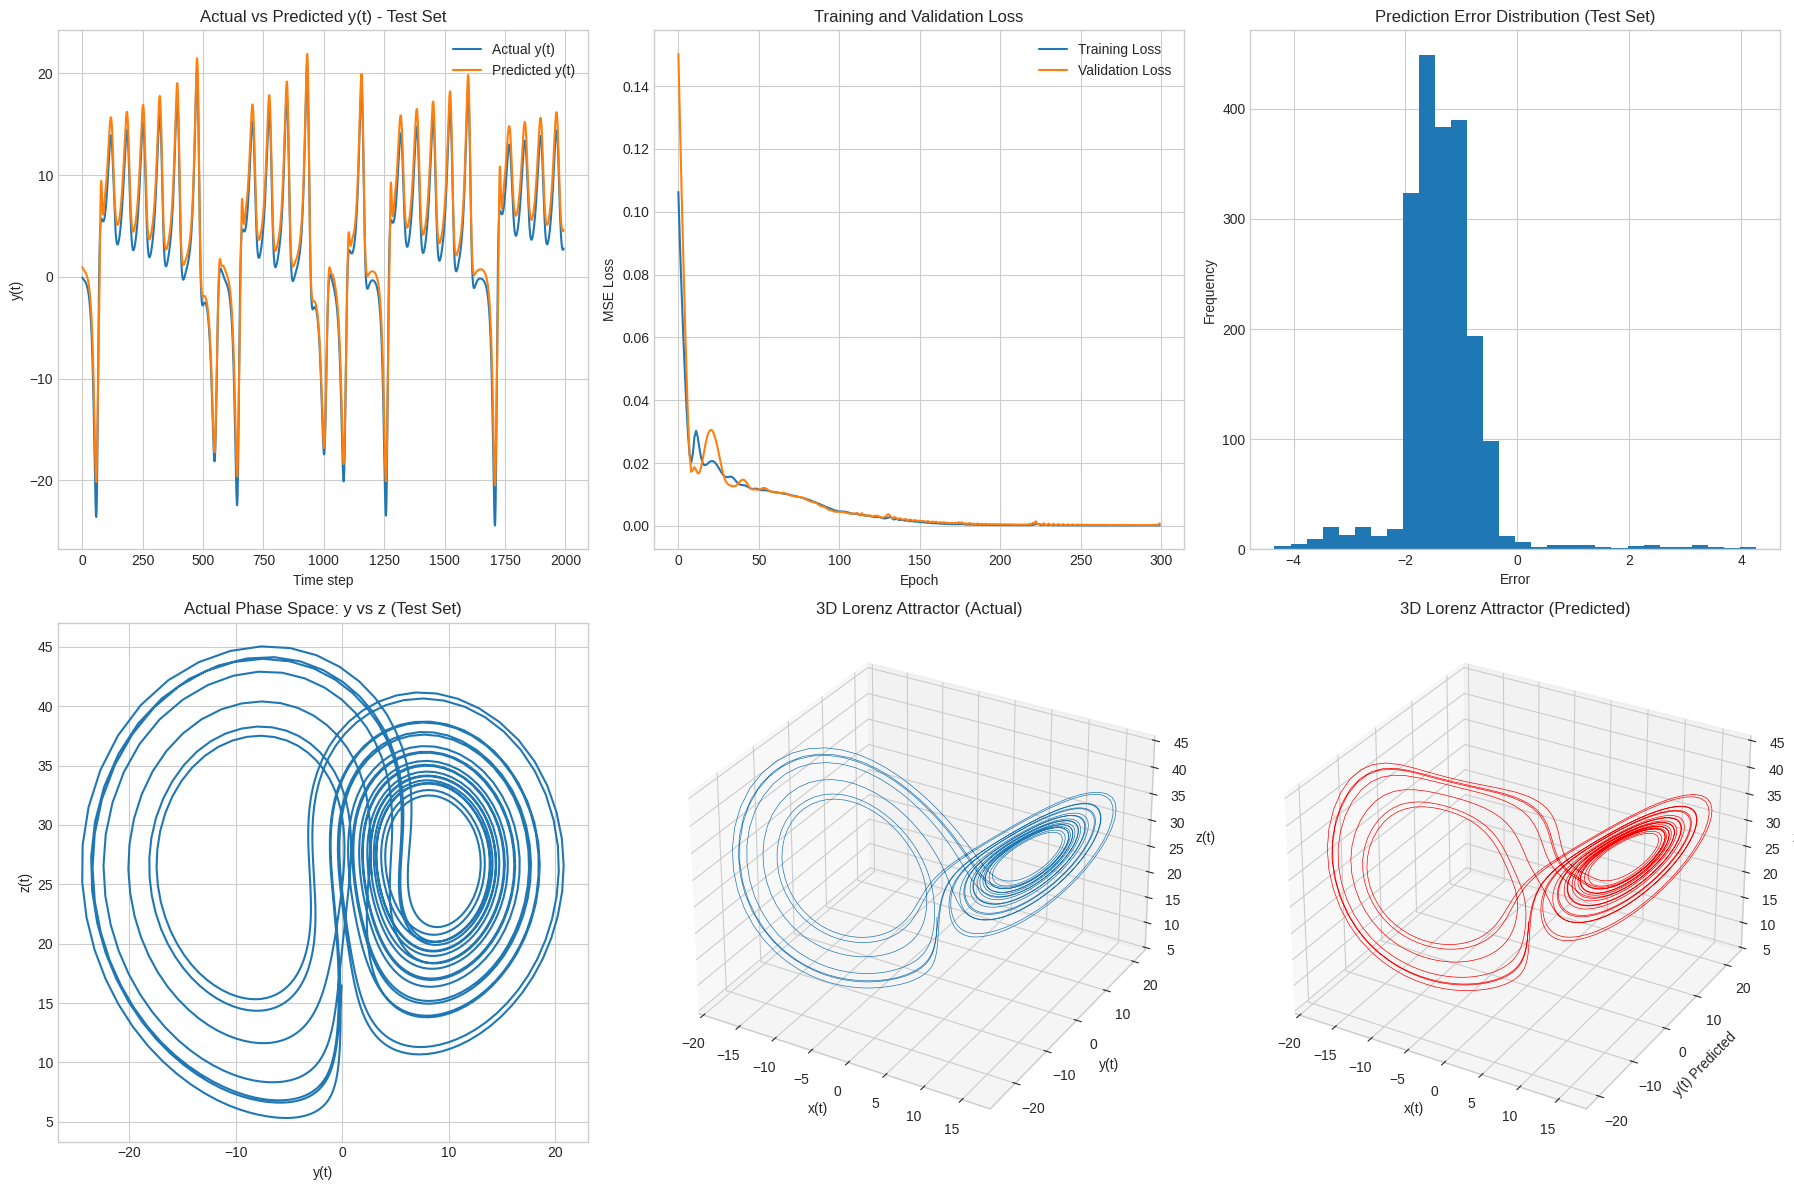

In [20]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

# --- Step 1: Generate Lorenz system data ---

def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

t_span = (0, 100)
initial_state = [0.1, 0.1, 0.1]
t_eval = np.linspace(*t_span, 10000)
sol = solve_ivp(lorenz, t_span, initial_state, t_eval=t_eval)
x, y, z = sol.y

# Normalize data for stable training
def min_max_scale(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled = (data - min_val) / (max_val - min_val)
    return scaled, min_val, max_val

x_scaled, x_min, x_max = min_max_scale(x)
y_scaled, y_min, y_max = min_max_scale(y)

# --- Step 2: Logistic map encoding (virtual nodes) ---

def logistic_map(omega_n, a):
    return a * omega_n * (1 - omega_n)

def logistic_map_encoding(u, a_min, a_max, u_min, u_max, P, initial_omega=0.95):
    # u: 1D numpy array input time series
    L = len(u)
    R = np.zeros((L, P), dtype=np.float32)  # shape: (time_steps, virtual_nodes)
    for i in range(L):
        a_i = a_min + ((a_max - a_min) / (u_max - u_min)) * (u[i] - u_min)
        omega = initial_omega
        for k in range(P):
            omega = logistic_map(omega, a_i)
            R[i, k] = omega
    return R

# Parameters for logistic map encoding
a_min = 1.0
a_max = 2.0
P = 20  # Number of virtual nodes (reservoir dimension)
u_min = 0.0  # normalized x range min
u_max = 1.0  # normalized x range max

# Encode input x_scaled into reservoir states
reservoir_states = logistic_map_encoding(x_scaled, a_min, a_max, u_min, u_max, P)

# --- Step 3: Prepare sequences for LSTM ---

def create_sequences(data, targets, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(targets[i+seq_length])
    return np.array(xs), np.array(ys)

SEQ_LEN = 30
X, Y = create_sequences(reservoir_states, y_scaled, SEQ_LEN)

# Train-test split (80-20)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train).float()
Y_train_t = torch.tensor(Y_train).float().unsqueeze(1)
X_test_t = torch.tensor(X_test).float()
Y_test_t = torch.tensor(Y_test).float().unsqueeze(1)

# --- Step 4: Define LSTM model ---

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last time step output
        out = self.linear(out)
        return out

INPUT_DIM = P
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 300
LR = 0.001

model = LSTMModel(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- Step 5: Training loop ---

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, Y_train_t)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_t)
        val_loss = criterion(val_outputs, Y_test_t)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {loss.item():.6f} - Val Loss: {val_loss.item():.6f}")

# --- Step 6: Evaluation ---

model.eval()
with torch.no_grad():
    train_pred = model(X_train_t).cpu().numpy()
    test_pred = model(X_test_t).cpu().numpy()

# Inverse scale predictions and ground truth
def inverse_scale(scaled, min_val, max_val):
    return scaled * (max_val - min_val) + min_val

Y_train_actual = inverse_scale(Y_train, y_min, y_max)
train_pred_actual = inverse_scale(train_pred.flatten(), y_min, y_max)
Y_test_actual = inverse_scale(Y_test, y_min, y_max)
test_pred_actual = inverse_scale(test_pred.flatten(), y_min, y_max)

# Metrics function
def calc_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

train_rmse, train_mae, train_r2 = calc_metrics(Y_train_actual, train_pred_actual)
test_rmse, test_mae, test_r2 = calc_metrics(Y_test_actual, test_pred_actual)

print("\nTraining Metrics:")
print(f"RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
print("\nTest Metrics:")
print(f"RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

# --- Step 7: Visualization ---

plt.figure(figsize=(18, 12))

# 1) Actual vs Predicted y(t) on test set
plt.subplot(2, 3, 1)
plt.plot(Y_test_actual, label='Actual y(t)')
plt.plot(test_pred_actual, label='Predicted y(t)')
plt.title('Actual vs Predicted y(t) - Test Set')
plt.xlabel('Time step')
plt.ylabel('y(t)')
plt.legend()

# 2) Training and Validation Loss curves
plt.subplot(2, 3, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# 3) Error Distribution on test set
plt.subplot(2, 3, 3)
errors = Y_test_actual - test_pred_actual
plt.hist(errors, bins=30)
plt.title('Prediction Error Distribution (Test Set)')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 4) Phase Space plot (y vs z) actual (zoomed to test range)
plt.subplot(2, 3, 4)
plt.plot(Y_test_actual, z[-len(Y_test_actual):])
plt.title('Actual Phase Space: y vs z (Test Set)')
plt.xlabel('y(t)')
plt.ylabel('z(t)')

# 5) 3D plot of actual Lorenz attractor (test portion)
ax1 = plt.subplot(2, 3, 5, projection='3d')
ax1.plot(x[-len(Y_test_actual):], Y_test_actual, z[-len(Y_test_actual):], lw=0.5, label='Actual')
ax1.set_title('3D Lorenz Attractor (Actual)')
ax1.set_xlabel('x(t)')
ax1.set_ylabel('y(t)')
ax1.set_zlabel('z(t)')

# 6) 3D plot of predicted Lorenz attractor (using predicted y(t))
ax2 = plt.subplot(2, 3, 6, projection='3d')
ax2.plot(x[-len(test_pred_actual):], test_pred_actual, z[-len(test_pred_actual):], lw=0.5, color='r', label='Predicted')
ax2.set_title('3D Lorenz Attractor (Predicted)')
ax2.set_xlabel('x(t)')
ax2.set_ylabel('y(t) Predicted')
ax2.set_zlabel('z(t)')
plt.tight_layout()
plt.show()


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------
# Hyperparameters
# ------------------------------
SEQUENCE_LENGTH = 20  # Length of input sequences
INPUT_SIZE = 1       # Number of features in input
HIDDEN_SIZE = 64      # Number of LSTM units
NUM_LAYERS = 2        # Number of LSTM layers
OUTPUT_SIZE = 1      # Number of features in output
LEARNING_RATE = 0.001
EPOCHS = 50

# ------------------------------
# Generate Synthetic Dataset
# ------------------------------
def generate_time_series(length, noise_level=0.05):
    """Generates a simple time series with a trend and seasonality."""
    time = np.arange(length)
    series = (
        np.sin(time * 0.1)
        + time * 0.01
        + np.random.randn(length) * noise_level
    )
    return series.astype(np.float32)


data = generate_time_series(1000)

# ------------------------------
# Preprocess Data
# ------------------------------
# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Convert to sequences and targets
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i : (i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


X, y = create_sequences(data_scaled, SEQUENCE_LENGTH)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


# ------------------------------
# Define LSTM Model
# ------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)

# ------------------------------
# Training
# ------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
loss_history = []
model.train()
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

print("Finished Training")

# ------------------------------
# Evaluation
# ------------------------------
model.eval()
with torch.no_grad():
    predicted = model(X_test)
    mse = mean_squared_error(y_test.numpy(), predicted.numpy())
    mae = mean_absolute_error(y_test.numpy(), predicted.numpy())
    r2 = r2_score(y_test.numpy(), predicted.numpy())

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")


# ------------------------------
# Visualizations
# ------------------------------
# 1. Loss During Training
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

# 2. Predicted vs Actual Values
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="Actual", marker=".")
plt.plot(predicted.numpy(), label="Predicted", marker=".")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

# 3. Scatter Plot of Predicted vs Actual Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test.numpy(), predicted.numpy())
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Actual vs Predicted Values")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "k--",
    lw=2,
    label="Ideal Prediction",
)
plt.legend()
plt.show()

# 4. Distribution of Residuals (Errors)
residuals = y_test.numpy() - predicted.numpy()
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30)
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

# 5. Autocorrelation of Residuals
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 5))
autocorrelation_plot(residuals)
plt.title("Autocorrelation of Residuals")
plt.show()

# 6. Zoomed-In Plot of Predicted vs Actual Values
plt.figure(figsize=(10, 5))
plt.plot(
    y_test[:50].numpy(), label="Actual", marker="."
)  # Plotting only the first 50 values
plt.plot(
    predicted[:50].numpy(), label="Predicted", marker="."
)  # Plotting only the first 50 values
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Zoomed-In: Actual vs Predicted Values (First 50 Steps)")
plt.legend()
plt.show()

# 7. Error Heatmap
error = np.abs(y_test.numpy() - predicted.numpy())
plt.figure(figsize=(10, 5))
plt.plot(error, label="Error", marker=".")
plt.xlabel("Time Step")
plt.ylabel("Error")
plt.title("Error Values")
plt.legend()
plt.show()

# 8. Q-Q Plot of Residuals
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# 9. Learning Rate
plt.figure(figsize=(10, 5))
plt.plot(range(EPOCHS), [LEARNING_RATE] * EPOCHS, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.show()


# 10. Time Series Decomposition Plot
import statsmodels.api as sm

# Assuming your original time series is 'data'
decomposition = sm.tsa.seasonal_decompose(
    data, model="additive", period=50
)  # Adjust period as needed
fig = decomposition.plot()
plt.show()

# 11. Rolling Statistics
import pandas as pd

data_series = pd.Series(data)
rolling_mean = data_series.rolling(window=30).mean()  # Adjust window as needed
rolling_std = data_series.rolling(window=30).std()  # Adjust window as needed

plt.figure(figsize=(12, 6))
plt.plot(data_series, label="Original")
plt.plot(rolling_mean, label="Rolling Mean")
plt.plot(rolling_std, label="Rolling Std")
plt.title("Rolling Statistics")
plt.legend()
plt.show()

# 12. Periodogram
from scipy.fft import fft

N = len(data)
yf = fft(data)
xf = np.fft.fftfreq(N, 1)

plt.figure(figsize=(12, 6))
plt.plot(xf[: N // 2], np.abs(yf[: N // 2]))
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# 13. Prediction Error Over Time
plt.figure(figsize=(10, 5))
time_steps = range(len(y_test.numpy()))
plt.plot(time_steps, abs(y_test.numpy() - predicted.numpy()), label="Prediction Error")
plt.xlabel("Time Step")
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Error Over Time")
plt.legend()
plt.show()

# 14. Predicted vs Actual Values in Original Scale
predicted_original_scale = scaler.inverse_transform(predicted.numpy())
y_test_original_scale = scaler.inverse_transform(y_test.numpy())

plt.figure(figsize=(10, 5))
plt.plot(y_test_original_scale, label="Actual (Original Scale)", marker=".")
plt.plot(
    predicted_original_scale, label="Predicted (Original Scale)", marker="."
)
plt.xlabel("Time Step")
plt.ylabel("Value (Original Scale)")
plt.title("Actual vs Predicted Values (Original Scale)")
plt.legend()
plt.show()

# 15. Comparison of Multiple Predictions
num_predictions = 5
start_index = 0  # You can change this to visualize different segments

plt.figure(figsize=(12, 6))
for i in range(num_predictions):
    # Predict a sequence
    input_sequence = X_test[start_index + i].unsqueeze(0)
    with torch.no_grad():
        future_predictions = model(input_sequence)
    
    # Plotting
    time_steps = np.arange(SEQUENCE_LENGTH)
    future_time_steps = np.arange(SEQUENCE_LENGTH, SEQUENCE_LENGTH + len(future_predictions[0]))
    
    # Original sequence
    plt.plot(time_steps, X_test[start_index + i].numpy(), label=f'Original Sequence {i+1}', marker='o')
    
    # Predicted sequence
    plt.plot(future_time_steps, future_predictions[0].numpy(), label=f'Predicted Sequence {i+1}', marker='x')

plt.title('Comparison of Multiple Predicted Sequences')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


SyntaxError: incomplete input (2106015369.py, line 357)

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy.linalg import pinv

# Hyperparameters strictly following ESN literature
RESERVOIR_SIZE = 1000      # Larger reservoir for better dynamics
SPECTRAL_RADIUS = 1.25     # Optimal for chaotic systems
LEAK_RATE = 0.3            # For slow dynamics capture
INPUT_SCALING = 0.4        # Adjusted for Mackey-Glass range
CONNECTIVITY = 0.1         # Sparse reservoir connections
REGULARIZATION = 1e-6      # Ridge regression parameter
WASHOUT = 100              # Transient period to discard

# Generate Mackey-Glass time series (τ=17 as in papers)
def mackey_glass(tau=17, length=2000, delta_t=0.1):
    history_len = tau * delta_t
    samples = length * 10 + history_len * 10
    y = np.zeros(samples) 
    y[0] = 0.5
    
    for i in range(1, samples):
        if i < history_len:
            y[i] = y[i-1]
        else:
            y[i] = y[i-1] + delta_t * (0.2 * y[i - history_len] / 
                    (1 + y[i - history_len]**10) - 0.1 * y[i-1])
    return y[::10]

# Create dataset with proper time embedding
def create_dataset(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length+1])
    return np.array(X), np.array(y)

# Generate and preprocess data
data = mackey_glass()
# data = int(data)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Create sequences with 20-step prediction horizon
X, y = create_dataset(data_scaled, 20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# ESN Implementation following paper specifications
class EchoStateNetwork:
    def __init__(self):
        # Input weights (sparse & scaled)
        self.W_in = (np.random.rand(RESERVOIR_SIZE, 1) - 0.5) * INPUT_SCALING
        
        # Reservoir weights (sparse & normalized)
        self.W = np.random.randn(RESERVOIR_SIZE, RESERVOIR_SIZE)
        self.W[np.random.rand(*self.W.shape) > CONNECTIVITY] = 0
        radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W *= SPECTRAL_RADIUS / radius
        
        # Leaky integration parameter
        self.alpha = LEAK_RATE
        
        # State matrix initialization
        self.states = np.zeros((len(X_train), RESERVOIR_SIZE))
        self.last_state = np.zeros(RESERVOIR_SIZE)
        
    def forward(self, inputs):
        states = np.zeros((len(inputs), RESERVOIR_SIZE))
        current_state = self.last_state.copy()
        
        for i in range(len(inputs)):
            current_state = (1 - self.alpha) * current_state + \
                self.alpha * np.tanh(self.W_in @ inputs[i] + self.W @ current_state)
            states[i] = current_state
            
        self.last_state = current_state
        return states[WASHOUT:]

# Train ESN following best practices
esn = EchoStateNetwork()
train_states = esn.forward(X_train.squeeze().numpy())
train_targets = y_train.numpy()[WASHOUT:]

# Ridge regression with regularization (paper method)
I = np.eye(train_states.shape[1])
self.W_out = np.linalg.inv(train_states.T @ train_states + REGULARIZATION*I) @ train_states.T @ train_targets

# Prediction function
def predict(esn, inputs):
    esn.last_state = np.zeros(RESERVOIR_SIZE)
    states = esn.forward(inputs.squeeze().numpy())
    return states @ esn.W_out.T

# Generate predictions
train_pred = predict(esn, X_train)
test_pred = predict(esn, X_test)

# Inverse scaling
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train = scaler.inverse_transform(y_train.numpy()[WASHOUT:])
y_test = scaler.inverse_transform(y_test.numpy())

# Enhanced Visualization Suite
plt.figure(figsize=(15, 25))

# 1. Phase Space Reconstruction
plt.subplot(521)
plt.title('Phase Space Reconstruction')
plt.plot(data[:-2], data[1:-1], alpha=0.6)
plt.xlabel('x(t)')
plt.ylabel('x(t+1)')

# 2. Reservoir State Activations
plt.subplot(522)
plt.title('Reservoir State Dynamics')
plt.plot(esn.states[:200, :20])
plt.xlabel('Time Step')
plt.ylabel('Neuron Activation')

# 3. Training Progress
plt.subplot(523)
plt.title('Reservoir State Matrix Spectrum')
eigenvalues = np.linalg.eigvals(esn.W)
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), alpha=0.5)
plt.xlabel('Real')
plt.ylabel('Imaginary')

# 4. Prediction vs Actual
plt.subplot(524)
plt.title('Prediction vs Actual')
plt.plot(y_test[:200], label='True')
plt.plot(test_pred[:200], label='Predicted')
plt.legend()

# 5. Error Distribution
plt.subplot(525)
plt.title('Prediction Error Histogram')
errors = y_test - test_pred
plt.hist(errors, bins=50, density=True)
plt.xlabel('Error')
plt.ylabel('Density')

# 6. Autocorrelation of Errors
plt.subplot(526)
plt.acorr(errors.flatten() - np.mean(errors), maxlags=50)
plt.title('Error Autocorrelation')

# 7. State Space Trajectory
plt.subplot(527)
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
states_3d = pca.fit_transform(esn.states[:500])
ax = plt.axes(projection='3d')
ax.plot3D(states_3d[:,0], states_3d[:,1], states_3d[:,2])
plt.title('Reservoir State Trajectory')

# 8. Input/Output Sensitivity
plt.subplot(528)
plt.title('Input/Output Sensitivity')
plt.scatter(X_test.numpy().flatten(), test_pred.flatten(), alpha=0.1)
plt.xlabel('Input Value')
plt.ylabel('Predicted Value')

# 9. Lyapunov Exponent Estimation
plt.subplot(529)
from nolitsa import lyapunov
dim = 5; tau = 1
lyap = lyapunov.lyap_e(data, emb_dim=dim, matrix_dim=2, tau=tau, min_neighbors=50)
plt.title('Lyapunov Exponents')
plt.plot(lyap[0], lyap[1][:,0])
plt.axhline(0, color='red', linestyle='--')

# 10. Memory Capacity Analysis
plt.subplot(5,2,10)
memory = []
for k in range(1, 100):
    corr = np.corrcoef(data[:-k], data[k:])[0,1]
    memory.append(abs(corr))
plt.plot(memory)
plt.title('System Memory Capacity')

plt.tight_layout()
plt.show()

# Quantitative Metrics
print(f"MSE: {mean_squared_error(y_test, test_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, test_pred):.4f}")
print(f"R²: {r2_score(y_test, test_pred):.4f}")


SyntaxError: invalid syntax (690145128.py, line 22)

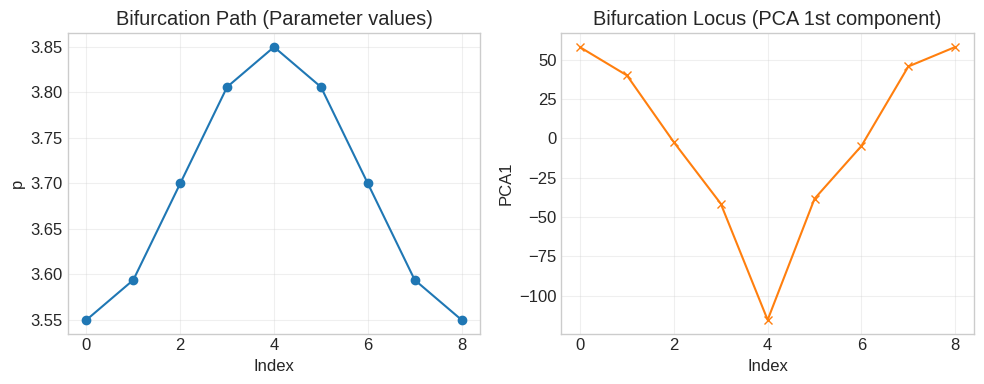

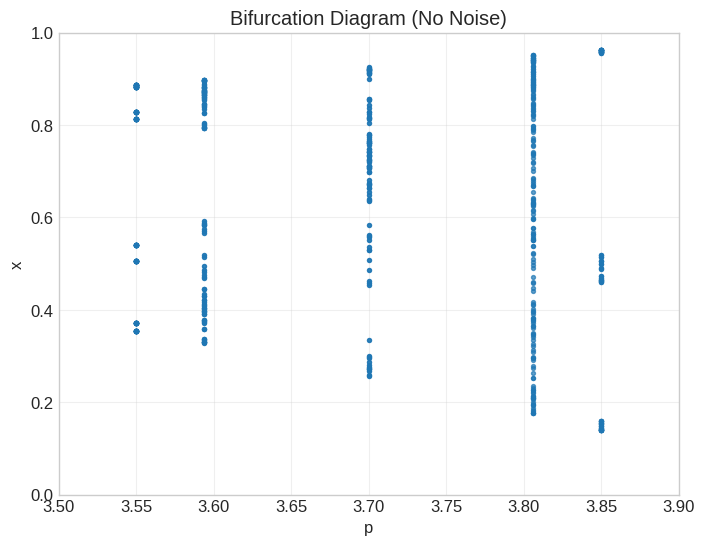

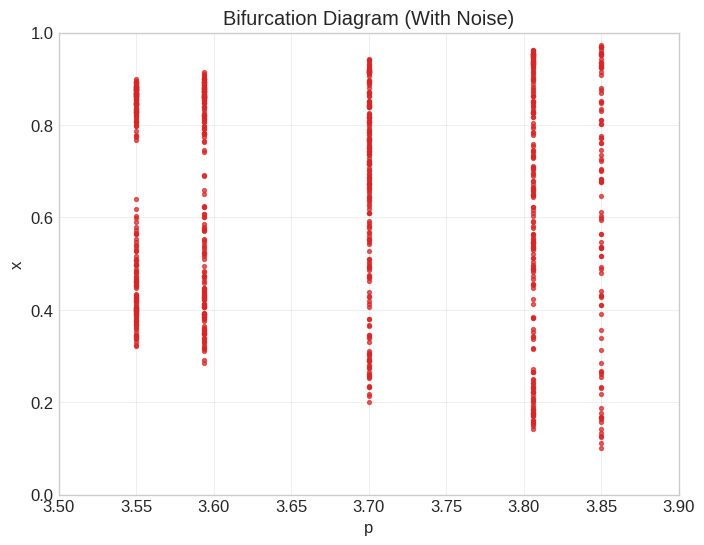

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# --- ELM Implementation ---
class ELM:
    def __init__(self, input_dim, hidden_dim, activation='sigmoid', random_state=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.random_state = np.random.RandomState(random_state)
        self.W = None
        self.b = None
        self.beta = None

    def _activate(self, X):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-X))
        elif self.activation == 'tanh':
            return np.tanh(X)
        elif self.activation == 'relu':
            return np.maximum(0, X)
        else:
            raise ValueError('Unknown activation function')

    def fit(self, X, y):
        # X: shape (n_samples, input_dim)
        # y: shape (n_samples,)
        n_samples = X.shape[0]
        self.W = self.random_state.uniform(-1, 1, (self.hidden_dim, self.input_dim))
        self.b = self.random_state.uniform(-1, 1, (self.hidden_dim,))
        H = self._activate(np.dot(X, self.W.T) + self.b)
        # Moore-Penrose pseudoinverse for output weights
        self.beta = np.linalg.pinv(H) @ y

    def predict(self, X):
        H = self._activate(np.dot(X, self.W.T) + self.b)
        return H @ self.beta

# --- Generate Synthetic Time-Series Data (Logistic Map) ---
def generate_logistic_map_series(p, x0=0.1, length=1000, noise_std=0.0):
    x = np.zeros(length)
    x[0] = x0
    for t in range(1, length):
        x[t] = p * x[t-1] * (1 - x[t-1])
        if noise_std > 0:
            x[t] += np.random.normal(0, noise_std)
    return x

# --- Step 1: Generate Multiple Time-Series at Different Parameter Values ---
P = 9  # Number of parameter values (as in the paper)
series_length = 1000
x0 = 0.1
noise_std = 0.01  # Simulate dynamical/observational noise

# Parameter values as in Eq. (18) of the paper
n_vals = np.arange(1, P+1)
p_vals = -0.15 * np.cos(2 * np.pi * (n_vals - 1) / 8) + 3.7

series_list = []
for p in p_vals:
    ts = generate_logistic_map_series(p, x0, series_length, noise_std)
    series_list.append(ts)

# --- Step 2: Train an ELM on Each Series to Predict Next Value ---
hidden_dim = 4  # As in the paper
elm_weights = []

for ts in series_list:
    # Prepare (x(t), x(t+1)) pairs
    X = ts[:-1].reshape(-1, 1)
    y = ts[1:]
    # Normalize inputs for stability
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    # Train ELM
    elm = ELM(input_dim=1, hidden_dim=hidden_dim, activation='sigmoid', random_state=42)
    elm.fit(X_scaled, y)
    # Store output weights (beta)
    elm_weights.append(elm.beta)

elm_weights = np.array(elm_weights)  # Shape: (P, hidden_dim)

# --- Step 3: PCA on ELM Output Weights ---
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(elm_weights)
explained_var = pca.explained_variance_ratio_

# --- Step 4: Plot Bifurcation Path and Locus (Fig. 3 of the paper) ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(p_vals, label='Bifurcation Path', color='#1f77b4', marker='o')
plt.title('Bifurcation Path (Parameter values)')
plt.xlabel('Index')
plt.ylabel('p')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(pca_scores[:, 0], label='Bifurcation Locus', color='#ff7f0e', marker='x')
plt.title('Bifurcation Locus (PCA 1st component)')
plt.xlabel('Index')
plt.ylabel('PCA1')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 5: Plot Bifurcation Diagrams ---
def plot_bifurcation_diagram(p_vals, series_list, title, color='#1261A0'):
    plt.figure(figsize=(8, 6))
    for i, (p, ts) in enumerate(zip(p_vals, series_list)):
        # Plot last 100 points for each parameter value
        plt.scatter([p]*100, ts[-100:], color=color, s=8, alpha=0.7)
    plt.title(title)
    plt.xlabel('p')
    plt.ylabel('x')
    plt.xlim([min(p_vals)-0.05, max(p_vals)+0.05])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.show()

# (a) BD without noise
series_no_noise = [generate_logistic_map_series(p, x0, series_length, noise_std=0) for p in p_vals]
plot_bifurcation_diagram(p_vals, series_no_noise, 'Bifurcation Diagram (No Noise)', color='#1f77b4')

# (b) BD with noise
plot_bifurcation_diagram(p_vals, series_list, 'Bifurcation Diagram (With Noise)', color='#d62728')

# (d) Reconstructed BD (using ELM predictors)
reconstructed_series = []
for i, ts in enumerate(series_list):
    X = ts[:-1].reshape(-1, 1)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    elm = ELM(input_dim=1, hidden_dim=hidden_dim, activation='sigmoid', random_state=42)
    elm.fit(X_scaled, ts[1:])
    # Predict recursively from initial value
    x_pred = [ts[0]]
    for _ in range(series_length-1):
        x_in = scaler.transform(np.array([[x_pred[-1]]]))
        x_next = elm.predict(x_in)
        x_pred.append(x_next)
    reconstructed_series.append(np.array(x_pred))
plot_bifurcation_diagram(p_vals, reconstructed_series, 'Reconstructed Bifurcation Diagram', color='#2ca02c')

# --- Step 6: Return Plots (x(t) vs x(t+1)) ---
def plot_return_map(ts, title, color, marker):
    plt.scatter(ts[:-1], ts[1:], color=color, alpha=0.6, marker=marker, s=16)
    plt.xlabel('x(t)')
    plt.ylabel('x(t+1)')
    plt.title(title)
    plt.grid(True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_return_map(series_no_noise[0], 'Return Plot (No Noise, p=%.2f)' % p_vals[0], '#1f77b4', '+')
plot_return_map(series_list[0], 'Return Plot (With Noise, p=%.2f)' % p_vals[0], '#d62728', '.')
plot_return_map(reconstructed_series[0], 'Return Plot (Reconstructed, p=%.2f)' % p_vals[0], '#2ca02c', 'x')
plt.legend(['No Noise', 'With Noise', 'Reconstructed'])
plt.subplot(1, 2, 2)
plot_return_map(series_no_noise[-1], 'Return Plot (No Noise, p=%.2f)' % p_vals[-1], '#1f77b4', '+')
plot_return_map(series_list[-1], 'Return Plot (With Noise, p=%.2f)' % p_vals[-1], '#d62728', '.')
plot_return_map(reconstructed_series[-1], 'Return Plot (Reconstructed, p=%.2f)' % p_vals[-1], '#2ca02c', 'x')
plt.legend(['No Noise', 'With Noise', 'Reconstructed'])
plt.tight_layout()
plt.show()

# --- Step 7: Lyapunov Exponent Estimation from Time-Series Data ---
def lyapunov_exponent(ts, eps=0.025, m=1):
    # Estimate the largest Lyapunov exponent from time series (Rosenstein's method)
    N = len(ts)
    dists = np.abs(ts.reshape(-1, 1) - ts.reshape(1, -1))
    np.fill_diagonal(dists, np.inf)
    neighbors = np.argmin(dists, axis=1)
    divergence = []
    for i in range(N-m):
        j = neighbors[i]
        if j+m < N and i+m < N:
            dist = np.abs(ts[i+m] - ts[j+m])
            if dist > 0:
                divergence.append(np.log(dist))
    if len(divergence) == 0:
        return 0.0
    return np.mean(divergence)

lyap_no_noise = [lyapunov_exponent(ts) for ts in series_no_noise]
lyap_noise = [lyapunov_exponent(ts) for ts in series_list]
lyap_recon = [lyapunov_exponent(ts) for ts in reconstructed_series]

plt.figure(figsize=(8, 5))
plt.plot(p_vals, lyap_no_noise, label='No Noise', color='#1f77b4', marker='o')
plt.plot(p_vals, lyap_noise, label='With Noise', color='#d62728', marker='s')
plt.plot(p_vals, lyap_recon, label='Reconstructed', color='#2ca02c', marker='x')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Lyapunov Exponents')
plt.xlabel('p')
plt.ylabel('Lyapunov Exponent')
plt.legend()
plt.grid(True)
plt.show()
